# Single cell analysis

In [1]:
# try:
#     import varseek as vk
# except ImportError:
#     print("varseek not found, installing...")
#     !pip install -U -q varseek
# try:
#     import RLSRP_2025
# except ImportError:
#     print("RLSRP_2025 not found, installing...")
#     !pip install -q git+https://github.com/pachterlab/RLSRP_2025.git
# try:
#     import gget
# except ImportError:
#     print("gget not found, installing...")
#     !pip install -U -q gget

In [2]:
import os
import anndata as ad
import pandas as pd
import seaborn as sns
import gget
import subprocess
import ast
import numpy as np
import shutil
from scipy import sparse
import matplotlib.pyplot as plt
import varseek as vk
import scanpy as sc
from RLSRP_2025.constants import box_links_dict

RLSRP_2025_dir = os.path.dirname(os.path.abspath(""))  # if this notebook resides in RLSRP_2025/notebooks/0_data_download.ipynb, then this retrieves RLSRP_2025

In [3]:
do_cbio_gene_filtering = True  # run with both True and False
number_cbio_samples = 10
custom_genes = ["EGFR", "SOX9", "NFIB"]  # genes beyond what I identify in cbioportal

vk_count_out_dir = os.path.join(RLSRP_2025_dir, "data", "vk_count_out_fig1")
adata_path = os.path.join(vk_count_out_dir, "adata_cleaned.h5ad")
adata_reference_genome_path = os.path.join(vk_count_out_dir, "adata_reference_genome_cleaned.h5ad")

child_out_dir = "single_cell_analysis" if not do_cbio_gene_filtering else "single_cell_analysis_cbioportal_filtered"
out_dir = os.path.join(vk_count_out_dir, "analysis", child_out_dir)

cbioportal_mutated_genes_path = os.path.join(out_dir, "Mutated_Genes.txt")
gbm_metadata_path = os.path.join(out_dir, "GBM_metadata.csv")
gbm_metadata_sra_path = os.path.join(RLSRP_2025_dir, "data", "glioblastoma_smartseq_fastq_data", "SraRunTable.csv")

reference_dir = os.path.join(RLSRP_2025_dir, "data", "reference")
cosmic_csv = os.path.join(reference_dir, "cosmic", "CancerMutationCensus_AllData_Tsv_v101_GRCh37", "CancerMutationCensus_AllData_v101_GRCh37_mutation_workflow.csv")
cosmic_cgc_path = os.path.join(reference_dir, "cosmic", "Cosmic_CancerGeneCensus_Tsv_v101_GRCh37", "Cosmic_CancerGeneCensus_v101_GRCh37.tsv")
sequences_cds = os.path.join(reference_dir, "ensembl_grch37_release93", "Homo_sapiens.GRCh37.cds.all.fa")
sequences_cdna = os.path.join(reference_dir, "ensembl_grch37_release93", "Homo_sapiens.GRCh37.cdna.all.fa")
t2g_file = os.path.join(reference_dir, "ensembl_grch37_release93", "t2g.txt")

Download data

In [4]:
if not os.path.isfile(adata_path):
    vk.utils.download_box_url(box_links_dict["glioblastoma_smartseq_adata_vcrs"], output_file_name=adata_path)
if not os.path.isfile(adata_reference_genome_path):
    vk.utils.download_box_url(box_links_dict["glioblastoma_smartseq_adata_reference_genome"], output_file_name=adata_reference_genome_path)
if not os.path.isfile(cosmic_csv):
    gget.cosmic(None, grch_version=37, cosmic_version=101, out=os.path.dirname(cosmic_csv), cosmic_project="cancer", download_cosmic=True, gget_mutate=True, keep_genome_info=True, remove_duplicates=True)
if not os.path.isfile(cosmic_cgc_path):
    raise FileExistsError(f"{cosmic_cgc_path} does not exist. Download by visiting https://www.cosmickb.org → click 'download data' → release 101 → download Cancer Gene Census data (GRCh37).")
if not os.path.isfile(gbm_metadata_path):
    raise FileExistsError(f"{gbm_metadata_path} does not exist. Download by visiting http://gbmseq.org → click 'download data' → go to 'GBM_metadata.csv'")
if not os.path.isfile(cbioportal_mutated_genes_path) and do_cbio_gene_filtering:
    raise FileExistsError(f"{cbioportal_mutated_genes_path} does not exist. Download by visiting https://www.cbioportal.org/study/summary?id=gbm_tcga_pan_can_atlas_2018 → click 'mutated genes'")
if not os.path.isfile(gbm_metadata_sra_path):
    raise FileExistsError(f"{gbm_metadata_sra_path} does not exist. Download by visiting https://www.ncbi.nlm.nih.gov/Traces/study/?acc=PRJNA330719&o=acc_s%3Aa → clicl 'metadata'")

os.makedirs(out_dir, exist_ok=True)

In [5]:
adata = ad.read_h5ad(adata_path)
adata_reference_genome = ad.read_h5ad(adata_reference_genome_path)

cosmic_df = pd.read_csv(cosmic_csv)
cosmic_cgc_df = pd.read_csv(cosmic_cgc_path, sep="\t")
metadata_df = pd.read_csv(gbm_metadata_path, sep=" ")
cbioportal_mutated_genes_df = pd.read_csv(cbioportal_mutated_genes_path, sep="\t")
metadata_df_sra = pd.read_csv(gbm_metadata_sra_path)

In [6]:
adata.var.head()

,vcrs_id,vcrs_header,seq_ID,mutation_cdna,nucleotide_positions,actual_variant,start_variant_position,end_variant_position,variant_source,gene_name,vcrs_header_with_gene_name,vcrs_count,vcrs_detected,gene_count,number_obs
variant,,,,,,,,,,,,,,,
ENST00000391429:c.194C>T,ENST00000391429:c.194C>T,ENST00000391429:c.194C>T,ENST00000391429,c.194C>T,194,C>T,194.0,194.0,transcriptome,ENSG00000205899,ENSG00000205899(ENST00000391429):c.194C>T,0.0,False,0,0
ENST00000391429:c.128C>A,ENST00000391429:c.128C>A,ENST00000391429:c.128C>A,ENST00000391429,c.128C>A,128,C>A,128.0,128.0,transcriptome,ENSG00000205899,ENSG00000205899(ENST00000391429):c.128C>A,0.0,False,0,0
ENST00000391429:c.257C>A,ENST00000391429:c.257C>A,ENST00000391429:c.257C>A,ENST00000391429,c.257C>A,257,C>A,257.0,257.0,transcriptome,ENSG00000205899,ENSG00000205899(ENST00000391429):c.257C>A,0.0,False,0,0
ENST00000391429:c.100G>A,ENST00000391429:c.100G>A,ENST00000391429:c.100G>A,ENST00000391429,c.100G>A,100,G>A,100.0,100.0,transcriptome,ENSG00000205899,ENSG00000205899(ENST00000391429):c.100G>A,0.0,False,0,0
ENST00000391429:c.99G>A,ENST00000391429:c.99G>A,ENST00000391429:c.99G>A,ENST00000391429,c.99G>A,99,G>A,99.0,99.0,transcriptome,ENSG00000205899,ENSG00000205899(ENST00000391429):c.99G>A,0.0,False,0,0


In [7]:
cosmic_df.head()

,seq_ID,mutation,mutation_aa,gene_name,mutation_id,mutation_cdna,header
0,ENST00000396153,c.1468C>T,p.Q490*,FAF1,48293736,c.1920C>T,ENST00000396153:c.1920C>T
1,ENST00000396153,c.711G>T,p.W237C,FAF1,48304295,c.1163G>T,ENST00000396153:c.1163G>T
2,ENST00000396153,c.1548C>T,p.R516=,FAF1,48302907,c.2000C>T,ENST00000396153:c.2000C>T
3,ENST00000396153,c.429del,p.G144Afs*13,FAF1,48291600,c.881del,ENST00000396153:c.881del
4,ENST00000396153,c.797G>A,p.G266E,FAF1,48301048,c.1249G>A,ENST00000396153:c.1249G>A


In [8]:
cosmic_cgc_df.head()

,GENE_SYMBOL,NAME,COSMIC_GENE_ID,CHROMOSOME,GENOME_START,GENOME_STOP,CHR_BAND,SOMATIC,GERMLINE,TUMOUR_TYPES_SOMATIC,TUMOUR_TYPES_GERMLINE,CANCER_SYNDROME,TISSUE_TYPE,MOLECULAR_GENETICS,ROLE_IN_CANCER,MUTATION_TYPES,TRANSLOCATION_PARTNER,OTHER_GERMLINE_MUT,OTHER_SYNDROME,TIER,SYNONYMS
0,A1CF,APOBEC1 complementation factor,COSG46891,10,52559169.0,52645435.0,10q11.23,y,n,melanoma,NaN,NaN,E,NaN,oncogene,Mis,NaN,n,NaN,2,"A1CF,ENSG00000148584.10,Q9NQ94,29974,ACF,ACF64..."
1,ABI1,abl interactor 1,COSG5120,10,27035522.0,27150016.0,10p12.1,y,n,AML,NaN,NaN,L,Dom,"TSG, fusion",T,KMT2A,n,NaN,1,"ABI1,ENSG00000136754.12,Q8IZP0,10006,ABI-1,E3B1"
2,ABL1,"ABL proto-oncogene 1, non-receptor tyrosine ki...",COSG4968,9,133589333.0,133763062.0,9q34.12,y,n,"CML, ALL, T-ALL",NaN,NaN,L,Dom,"oncogene, fusion","T, Mis","BCR, ETV6, NUP214",n,NaN,1,"ABL1,ENSG00000097007.13,P00519,25,JTK7,c-ABL,p150"
3,ABL2,"ABL proto-oncogene 2, non-receptor tyrosine ki...",COSG36573,1,179068462.0,179198819.0,1q25.2,y,n,AML,NaN,NaN,L,Dom,"oncogene, fusion",T,ETV6,n,NaN,1,"ABL2,ENSG00000143322.15,P42684,27,ARG"
4,ACKR3,atypical chemokine receptor 3,COSG38910,2,237476430.0,237491001.0,2q37.3,y,n,lipoma,NaN,NaN,M,Dom,"oncogene, fusion",T,HMGA2,n,NaN,1,"ACKR3,ENSG00000144476.5,P25106,57007,GPR159,RDC1"


In [9]:
cbioportal_mutated_genes_df = cbioportal_mutated_genes_df.sort_values(by="#", ascending=False)
cbioportal_mutated_genes_df.head()

,Gene,MutSig(Q-value),# Mut,#,Profiled Samples,Freq,Is Cancer Gene (source: OncoKB)
3608,PTEN,NaN,138,133,397,33.5%,Yes
10720,TP53,NaN,149,125,397,31.5%,Yes
7725,TTN,NaN,202,101,397,25.4%,No
12205,EGFR,NaN,117,94,397,23.7%,Yes
5513,MUC16,NaN,103,61,397,15.4%,No


In [10]:
metadata_df.head()

,Sample.type,Selection,Location,Sample.name,Total_reads,Unique_reads,Unique_reads_percent,Splice_sites_total,Splice_sites_Annotated,Splice_sites_GT.AG,Splice_sites_GC.AG,Splice_sites_AT.AC,Splice_sites_non_canonical,Multimapping_reads_percent,Unmapped_mismatch,Unmapped_short,Unmapped_other,ERCC_reads,Non_ERCC_reads,ERCC_to_non_ERCC,Genes_detected,housekeeping_cluster,housekeeping_cluster_color,Sample.type.color,Selection.color,Sample.name.color,Location.color,Cluster_2d,Cluster_2d_color
1001000173.G8,Glioblastoma,Unpanned,Tumor,BT_S2,1741039,1400382,80.43,126660,122397,125741,761,102,56,2.67,2.15,14.56,0.18,152104,270429,0.562454,1962,2,#AEC7E8,#1F77B4,#98DF8A,#AEC7E8,#FF7F0E,11,#8C564B
1001000173.D4,Glioblastoma,Unpanned,Tumor,BT_S2,1229919,1081271,87.91,106857,103763,105878,683,203,93,0.84,0.59,10.66,0.00,244319,169375,1.442474,515,2,#AEC7E8,#1F77B4,#98DF8A,#AEC7E8,#FF7F0E,2,#AEC7E8
1001000173.B4,Glioblastoma,Unpanned,Tumor,BT_S2,1483293,1301500,87.74,539234,531827,536121,2380,406,327,4.02,1.06,7.09,0.06,42559,727429,0.058506,5607,2,#AEC7E8,#1F77B4,#98DF8A,#AEC7E8,#FF7F0E,11,#8C564B
1001000173.A2,Glioblastoma,Unpanned,Tumor,BT_S2,1943210,1678256,86.37,469261,457505,465354,3105,355,447,2.95,1.31,9.23,0.13,106559,705661,0.151006,3856,2,#AEC7E8,#1F77B4,#98DF8A,#AEC7E8,#FF7F0E,11,#8C564B
1001000173.E2,Glioblastoma,Unpanned,Tumor,BT_S2,1968898,1656225,84.12,204141,195729,202753,1249,31,108,3.05,1.58,11.01,0.20,136919,390799,0.350357,2173,2,#AEC7E8,#1F77B4,#98DF8A,#AEC7E8,#FF7F0E,11,#8C564B


In [11]:
metadata_df_sra['experiment_name'] = metadata_df_sra["plate_id"].astype(str) + "." + metadata_df_sra["well"].astype(str)
metadata_df_sra.head()

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,cell_type,Center Name,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,diagnosis,Experiment,GEO_Accession (exp),Instrument,LibraryLayout,LibrarySelection,LibrarySource,neoplastic,Organism,Patient_ID,plate_id,Platform,ReleaseDate,Sample Name,Selection,source_name,SRA Study,tissue,tsne_cluster,well,create_date,version,experiment_name
0,SRR3934349,RNA-Seq,128,223967101,PRJNA330719,SAMN05421106,85578803,Neoplastic,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",glioblastoma,SRX1963641,GSM2243439,NextSeq 500,PAIRED,cDNA,TRANSCRIPTOMIC,Neoplastic,Homo sapiens,BT_S2,1001000173,ILLUMINA,2017-11-02T00:00:00Z,GSM2243439,Unpanned,Brain,SRP079058,Tumor,11,G8,2016-07-20T23:14:00Z,1.0,1001000173.G8
1,SRR3934350,RNA-Seq,128,158226652,PRJNA330719,SAMN05421107,60181027,Oligodendrocyte,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",glioblastoma,SRX1963642,GSM2243440,NextSeq 500,PAIRED,cDNA,TRANSCRIPTOMIC,Regular,Homo sapiens,BT_S2,1001000173,ILLUMINA,2017-11-02T00:00:00Z,GSM2243440,Unpanned,Brain,SRP079058,Tumor,2,D4,2016-07-20T23:13:00Z,1.0,1001000173.D4
2,SRR3934351,RNA-Seq,128,190712697,PRJNA330719,SAMN05421108,72386867,Neoplastic,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",glioblastoma,SRX1963643,GSM2243441,NextSeq 500,PAIRED,cDNA,TRANSCRIPTOMIC,Neoplastic,Homo sapiens,BT_S2,1001000173,ILLUMINA,2017-11-02T00:00:00Z,GSM2243441,Unpanned,Brain,SRP079058,Tumor,11,B4,2016-07-20T23:10:00Z,1.0,1001000173.B4
3,SRR3934352,RNA-Seq,128,249900053,PRJNA330719,SAMN05421109,95698536,Neoplastic,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",glioblastoma,SRX1963644,GSM2243442,NextSeq 500,PAIRED,cDNA,TRANSCRIPTOMIC,Neoplastic,Homo sapiens,BT_S2,1001000173,ILLUMINA,2017-11-02T00:00:00Z,GSM2243442,Unpanned,Brain,SRP079058,Tumor,11,A2,2016-07-20T23:10:00Z,1.0,1001000173.A2
4,SRR3934353,RNA-Seq,128,253252958,PRJNA330719,SAMN05421110,96374384,Neoplastic,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",glioblastoma,SRX1963645,GSM2243443,NextSeq 500,PAIRED,cDNA,TRANSCRIPTOMIC,Neoplastic,Homo sapiens,BT_S2,1001000173,ILLUMINA,2017-11-02T00:00:00Z,GSM2243443,Unpanned,Brain,SRP079058,Tumor,11,E2,2016-07-20T23:14:00Z,1.0,1001000173.E2


## Data cleaning

In [12]:
adata.var.head()

,vcrs_id,vcrs_header,seq_ID,mutation_cdna,nucleotide_positions,actual_variant,start_variant_position,end_variant_position,variant_source,gene_name,vcrs_header_with_gene_name,vcrs_count,vcrs_detected,gene_count,number_obs
variant,,,,,,,,,,,,,,,
ENST00000391429:c.194C>T,ENST00000391429:c.194C>T,ENST00000391429:c.194C>T,ENST00000391429,c.194C>T,194,C>T,194.0,194.0,transcriptome,ENSG00000205899,ENSG00000205899(ENST00000391429):c.194C>T,0.0,False,0,0
ENST00000391429:c.128C>A,ENST00000391429:c.128C>A,ENST00000391429:c.128C>A,ENST00000391429,c.128C>A,128,C>A,128.0,128.0,transcriptome,ENSG00000205899,ENSG00000205899(ENST00000391429):c.128C>A,0.0,False,0,0
ENST00000391429:c.257C>A,ENST00000391429:c.257C>A,ENST00000391429:c.257C>A,ENST00000391429,c.257C>A,257,C>A,257.0,257.0,transcriptome,ENSG00000205899,ENSG00000205899(ENST00000391429):c.257C>A,0.0,False,0,0
ENST00000391429:c.100G>A,ENST00000391429:c.100G>A,ENST00000391429:c.100G>A,ENST00000391429,c.100G>A,100,G>A,100.0,100.0,transcriptome,ENSG00000205899,ENSG00000205899(ENST00000391429):c.100G>A,0.0,False,0,0
ENST00000391429:c.99G>A,ENST00000391429:c.99G>A,ENST00000391429:c.99G>A,ENST00000391429,c.99G>A,99,G>A,99.0,99.0,transcriptome,ENSG00000205899,ENSG00000205899(ENST00000391429):c.99G>A,0.0,False,0,0


In [13]:
adata = adata[:, np.array((adata.X != 0).sum(axis=0)).flatten() > 0]  # Identify columns (variants) with non-zero counts across samples
adata = adata[:, ~adata.var_names.str.contains(";")]  # Identify columns (variants) with semicolon in name
adata

View of AnnData object with n_obs × n_vars = 3589 × 393915
    var: 'vcrs_id', 'vcrs_header', 'seq_ID', 'mutation_cdna', 'nucleotide_positions', 'actual_variant', 'start_variant_position', 'end_variant_position', 'variant_source', 'gene_name', 'vcrs_header_with_gene_name', 'vcrs_count', 'vcrs_detected', 'gene_count', 'number_obs'
    uns: 'corrected_barcodes'

In [14]:
adata.var = adata.var.drop(columns=["vcrs_id", "vcrs_detected", "variant_source"])  # drop vcrs_id (because it is a duplicate of vcrs_header)
adata.var = adata.var.rename(columns={"vcrs_header": "variant_name", "gene_name": "gene_id", "vcrs_header_with_gene_name": "variant_name_with_gene_id", "vcrs_count": "variant_count"})

# merge in cosmic without resetting index
old_var_names = adata.var_names.copy()
adata.var = adata.var.merge(cosmic_df[["seq_ID", "gene_name"]].drop_duplicates("seq_ID"), on="seq_ID", how="left").rename(columns={"gene_name": "gene_symbol"})
adata.var = adata.var.merge(cosmic_cgc_df[["GENE_SYMBOL", "TUMOUR_TYPES_SOMATIC", "TUMOUR_TYPES_GERMLINE", "ROLE_IN_CANCER"]], left_on="gene_symbol", right_on="GENE_SYMBOL", how="left")
adata.var = adata.var.drop(columns=["GENE_SYMBOL"])
adata.var_names = old_var_names

adata.var['variant_name_with_gene_name_instead_of_transcript_id'] = adata.var['gene_symbol'].astype(str) + ":" + adata.var['mutation_cdna'].astype(str)


adata.var["FCV"] = adata.var["number_obs"] / adata.shape[0]  # fraction of cells with variant - Fraction of Cells with Variant (FCV)

adata.var['variant_name_with_gene_name'] = (
    adata.var["gene_symbol"] + "(" +
    adata.var["variant_name"].str.split(":").str[0] + "):" +
    adata.var["variant_name"].str.split(":").str[1]
)

# reorder columns in adata.var
priority_cols = [
    "variant_name",
    "gene_symbol",
    "variant_count",
    "gene_count",
    "number_obs",
    "FCV",
    "ROLE_IN_CANCER",
    "TUMOUR_TYPES_SOMATIC",
    "TUMOUR_TYPES_GERMLINE",
]

# Get the remaining columns not in the priority list
remaining_cols = [col for col in adata.var.columns if col not in priority_cols]

# Reorder adata.var
adata.var = adata.var[priority_cols + remaining_cols]

adata.obs.index = adata.obs.index.astype(str)  # avoid Don’t call _normalize_index with non-categorical/string names
adata.var.index = adata.var.index.astype(str)  # avoid Don’t call _normalize_index with non-categorical/string names

## From their paper, Fig2a

In [15]:
cluster_color_to_identity_dict = {
    "1": "Neoplastic cells 1",  # cluster 1 from picture (counting from top left, going down and the across)
    "2": "Oligodendrocytes",  # cluster 10 from picture
    "3": "Vascular cells 1",  # cluster 4
    "4": "Neoplastic cells 2",  # cluster 2
    "5": "Neurons",  # cluster 9
    "6": "Vascular cells 2",  # cluster 5
    "7": "Myeloid cell 1",  # cluster 7
    "8": "Myeloid cell 2",  # cluster 8
    "9": "OPCs",  # cluster 11
    "10": "Astrocytes",  # cluster 12
    "11": "Neoplastic cells 3",  # cluster 3
    "12": "Vascular cells 3",  # cluster 6
}

metadata_df[['Cluster_2d', 'Cluster_2d_color']].drop_duplicates().sort_values('Cluster_2d')

,Cluster_2d,Cluster_2d_color
1001000175.F12,1,#1F77B4
1001000173.D4,2,#AEC7E8
1001000175.B6,3,#FF7F0E
1001000258.F11,4,#FFBB78
1001000175.H9,5,#2CA02C
1001000031.C5,6,#98DF8A
1001000173.D11,7,#D62728
1001000173.B6,8,#FF9896
1001000173.D6,9,#9467BD
1001000180.G9,10,#C5B0D5


In [16]:
kb_info_json_path = os.path.join(vk_count_out_dir, "kb_count_out_vcrs", "kb_info.json")

import json
import re
from collections import OrderedDict

# Load the JSON
with open(kb_info_json_path) as f:
    kb_info = json.load(f)

# Extract the call string
call_str = kb_info["call"]

# Find all .fastq file paths (ending in .fastq or .fastq.gz if needed)
fastq_files = re.findall(r'\S+\.fastq(?:\.gz)?', call_str)

fastq_file_bases = [os.path.basename(fastq_file).split("_")[0] for fastq_file in fastq_files]
unique_fastq_bases = list(OrderedDict.fromkeys(fastq_file_bases))  # remove duplicates while preserving order 
adata.obs['Run'] = unique_fastq_bases

In [17]:
adata.obs = adata.obs.reset_index().merge(metadata_df_sra[["Run", "experiment_name", "cell_type", "neoplastic", "Patient_ID", "tissue", "tsne_cluster"]], on="Run", how="left").rename(columns={"cell_type": "cell_type_sra"}).set_index('barcode')
adata.obs["cell_type"] = adata.obs["tsne_cluster"].astype(str).map(cluster_color_to_identity_dict)
adata.obs["cell_type_broad"] = adata.obs["cell_type"].apply(lambda x: x.rsplit(" ", 1)[0])

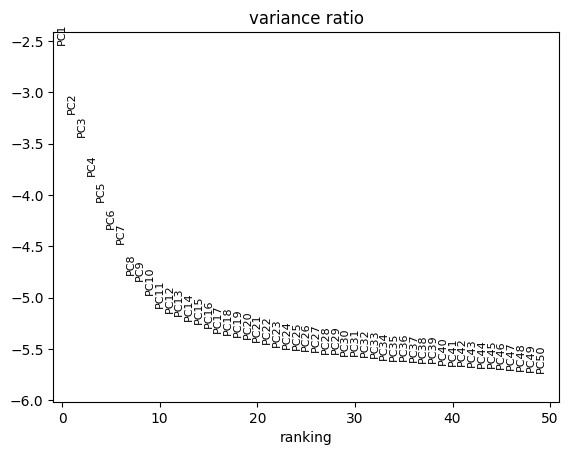

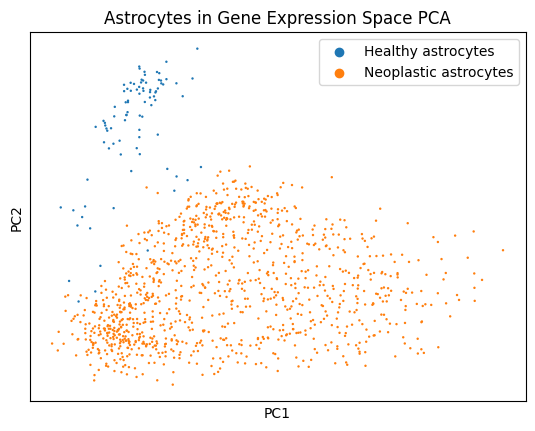

2025-07-27 19:28:41.732078: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


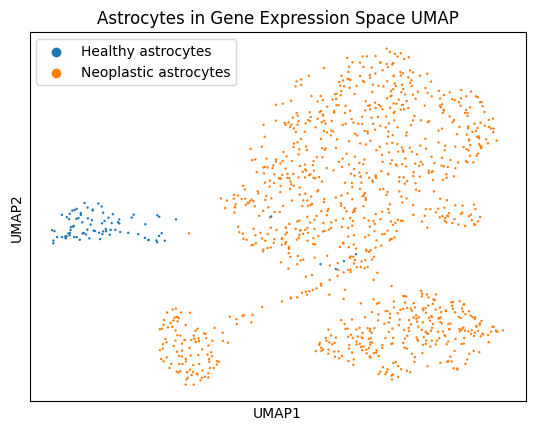

In [18]:
def plot_pca(adata, min_samples_per_variant=3, normalize_adata=False, log_adata=False, n_top_variants=None, batch_key=None, do_scaling=False, mean_centering=False, n_pcs=50, size=12, remove_outliers=False, use_binary_matrix=False, save=None):
    adata = adata.copy()
    adata_original = adata.copy()
    if use_binary_matrix:
        adata.X = (adata.X > 0).astype(int)
        if log_adata or do_scaling:
            print("Binary matrix means do not log1p or scale")
        log_adata = False
        if do_scaling:
            mean_centering = True
        do_scaling = False
    if do_scaling and mean_centering:
        print("Mean scaling and scaling are mutually exclusive, setting mean_centering to False")
        mean_centering = False
    sc.pp.filter_genes(adata, min_cells=min_samples_per_variant)
    if normalize_adata:
        sc.pp.normalize_total(adata, target_sum=1e6)
    if log_adata:
        sc.pp.log1p(adata)
    if n_top_variants is not None:
        sc.pp.highly_variable_genes(adata, n_top_genes=n_top_variants, batch_key=batch_key)  # batch_key="Population name"
    if do_scaling:
        adata.raw = adata.copy()
        sc.pp.scale(adata, max_value=None)
    if mean_centering:
        if sparse.issparse(adata.X):
            means = np.array(adata.X.mean(axis=0)).ravel()
            adata.X = adata.X - means  # sparse broadcast
        else:
            adata.X = adata.X - adata.X.mean(axis=0)

    sc.tl.pca(adata)
    if remove_outliers:  # removes outlier greater than 5 standard deviations from the mean in PC1
        pc1 = adata.obsm['X_pca'][:, 0]
        z_scores = np.abs((pc1 - pc1.mean()) / pc1.std())
        threshold = 5
        keep_cells = z_scores <= threshold
        adata = adata_original[keep_cells].copy()
        plot_pca(adata=adata, min_samples_per_variant=min_samples_per_variant, normalize_adata=normalize_adata, log_adata=log_adata, n_top_variants=n_top_variants, batch_key=batch_key, do_scaling=do_scaling, mean_centering=mean_centering, n_pcs=n_pcs, size=size, remove_outliers=False, use_binary_matrix=use_binary_matrix, save=save)
        return adata
    sc.pl.pca_variance_ratio(adata, n_pcs=n_pcs, log=True)
    
    sc.pl.pca(
        adata,
        color=["cell_type_broad"],
        dimensions=[(0, 1)],
        size=size,
        save=False,
        show=False
    )
    plt.title("Astrocytes in Gene Expression Space PCA")

    # change labels
    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    label_map = {
        "Neoplastic cells": "Neoplastic astrocytes",
        "Astrocytes": "Healthy astrocytes"
    }
    new_labels = [label_map.get(label, label) for label in labels]
    ax.legend(handles, new_labels)

    if bool(save):
        plt.savefig(save, bbox_inches="tight")
    plt.show()
    plt.close()
    return adata

def plot_umap(adata, save=None):
    adata = adata.copy()
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)

    sc.pl.umap(
        adata,
        color="cell_type_broad",
        size=12,
        save=False,
        show=False
    )
    
    plt.title("Astrocytes in Gene Expression Space UMAP")

    # change labels
    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    label_map = {
        "Neoplastic cells": "Neoplastic astrocytes",
        "Astrocytes": "Healthy astrocytes"
    }
    new_labels = [label_map.get(label, label) for label in labels]
    ax.legend(handles, new_labels)

    if bool(save):
        plt.savefig(save, bbox_inches="tight")
    plt.show()
    plt.close()

categories_to_keep = ["Neoplastic cells", "Astrocytes"]
# adata_astrocytes = adata[adata.obs["cell_type_broad"].isin(categories_to_keep)].copy()
# _ = plot_pca(adata_astrocytes, min_samples_per_variant=3, log_adata=False, n_top_variants=None, batch_key=None, do_scaling=False, n_pcs=50, size=12, use_binary_matrix=True, mean_centering=False)

if 'experiment_name' not in adata_reference_genome.obs.columns:  # just to avoid running this more than once if I repeat the cell
    adata_reference_genome.obs = adata_reference_genome.obs.join(adata.obs, how='left')
# adata_reference_genome.obs['Run'] = unique_fastq_bases
# adata_reference_genome.obs = adata_reference_genome.obs.reset_index().merge(metadata_df_sra[["Run", "experiment_name", "cell_type", "neoplastic", "Patient_ID", "tissue", "tsne_cluster"]], on="Run", how="left").rename(columns={"cell_type": "cell_type_sra"}).set_index('barcode')
# adata_reference_genome.obs["cell_type"] = adata_reference_genome.obs["tsne_cluster"].astype(str).map(cluster_color_to_identity_dict)
# adata_reference_genome.obs["cell_type_broad"] = adata_reference_genome.obs["cell_type"].apply(lambda x: x.rsplit(" ", 1)[0])
adata_reference_genome_astrocytes = adata_reference_genome[adata_reference_genome.obs["cell_type_broad"].isin(categories_to_keep)].copy()
adata_reference_genome_astrocytes_output = plot_pca(adata_reference_genome_astrocytes, min_samples_per_variant=3, normalize_adata=True, log_adata=True, n_top_variants=2000, batch_key=None, do_scaling=False, n_pcs=50, size=12, use_binary_matrix=False, mean_centering=False, save=os.path.join(out_dir, "adata_reference_genome_astrocytes_pca.pdf"))
plot_umap(adata_reference_genome_astrocytes_output, save=os.path.join(out_dir, "adata_reference_genome_astrocytes_umap.pdf"))

## Cbioportal filtering

In [19]:
# Filter to keep only rows where "#" is >= number_cbio_samples
cbioportal_mutated_genes_df_top = cbioportal_mutated_genes_df[cbioportal_mutated_genes_df["#"] >= number_cbio_samples]

# only keep columns of adata where adata.var['gene_symbol'] is in cbioportal_mutated_genes_df['Gene'].unique()
gbm_genes = set(cbioportal_mutated_genes_df_top['Gene'].unique())
gbm_genes.update(custom_genes)

if do_cbio_gene_filtering:
    adata = adata[:, adata.var['gene_symbol'].isin(gbm_genes)]
    print(adata)
else:
    adata_cbio = adata[:, adata.var['gene_symbol'].isin(gbm_genes)]
    print(adata_cbio)

View of AnnData object with n_obs × n_vars = 3589 × 12253
    obs: 'Run', 'experiment_name', 'cell_type_sra', 'neoplastic', 'Patient_ID', 'tissue', 'tsne_cluster', 'cell_type', 'cell_type_broad'
    var: 'variant_name', 'gene_symbol', 'variant_count', 'gene_count', 'number_obs', 'FCV', 'ROLE_IN_CANCER', 'TUMOUR_TYPES_SOMATIC', 'TUMOUR_TYPES_GERMLINE', 'seq_ID', 'mutation_cdna', 'nucleotide_positions', 'actual_variant', 'start_variant_position', 'end_variant_position', 'gene_id', 'variant_name_with_gene_id', 'variant_name_with_gene_name_instead_of_transcript_id', 'variant_name_with_gene_name'
    uns: 'corrected_barcodes'


### The original manuscript made a point about EGFR and SOX9 expression as differentiating nicely between healthy vs neoplastic. How about on the variant side of things?

In [20]:
number_egfr_mutations_in_cosmic = len(cosmic_df.loc[cosmic_df['gene_name'] == "EGFR"])
number_sox9_mutations_in_cosmic = len(cosmic_df.loc[cosmic_df['gene_name'] == "SOX9"])

print(f"Number of mutations in EGFR in COSMIC: {number_egfr_mutations_in_cosmic}")
print(f"Number of mutations in SOX9 in COSMIC: {number_sox9_mutations_in_cosmic}")
print(f"Ratio of EGFR to SOX9 mutations in COSMIC: {number_egfr_mutations_in_cosmic / number_sox9_mutations_in_cosmic:.2f}")

Number of mutations in EGFR in COSMIC: 1734
Number of mutations in SOX9 in COSMIC: 721
Ratio of EGFR to SOX9 mutations in COSMIC: 2.40


### Ok, so if things were linear, I would expect 2.4x more EGFR mutations than SOX9 mutations

### Filter to Astrocytes and Neoplastic Cells

In [21]:
# adata.obs.index = adata.obs.index.astype(str)  # avoid Don’t call _normalize_index with non-categorical/string names
categories_to_keep = ["Neoplastic cells", "Astrocytes"]
adata_astrocytes = adata[adata.obs["cell_type_broad"].isin(categories_to_keep)].copy()

### Count number of cells in each category

In [22]:
cell_type_counts = adata_astrocytes.obs["cell_type_broad"].value_counts()
cell_type_counts

cell_type_broad
Neoplastic cells    1091
Astrocytes            88
Name: count, dtype: int64

In [23]:
adata_astrocytes.var.head()

,variant_name,gene_symbol,variant_count,gene_count,number_obs,FCV,ROLE_IN_CANCER,TUMOUR_TYPES_SOMATIC,TUMOUR_TYPES_GERMLINE,seq_ID,mutation_cdna,nucleotide_positions,actual_variant,start_variant_position,end_variant_position,gene_id,variant_name_with_gene_id,variant_name_with_gene_name_instead_of_transcript_id,variant_name_with_gene_name
variant,,,,,,,,,,,,,,,,,,,
ENST00000256646:c.847C>T,ENST00000256646:c.847C>T,NOTCH2,2.0,189,1,0.000279,"oncogene, TSG","marginal zone lymphoma, DLBCL, bladder",NaN,ENST00000256646,c.847C>T,847,C>T,847.0,847.0,ENSG00000134250,ENSG00000134250(ENST00000256646):c.847C>T,NOTCH2:c.847C>T,NOTCH2(ENST00000256646):c.847C>T
ENST00000256646:c.7169C>T,ENST00000256646:c.7169C>T,NOTCH2,3.0,189,1,0.000279,"oncogene, TSG","marginal zone lymphoma, DLBCL, bladder",NaN,ENST00000256646,c.7169C>T,7169,C>T,7169.0,7169.0,ENSG00000134250,ENSG00000134250(ENST00000256646):c.7169C>T,NOTCH2:c.7169C>T,NOTCH2(ENST00000256646):c.7169C>T
ENST00000256646:c.6314C>T,ENST00000256646:c.6314C>T,NOTCH2,2.0,189,1,0.000279,"oncogene, TSG","marginal zone lymphoma, DLBCL, bladder",NaN,ENST00000256646,c.6314C>T,6314,C>T,6314.0,6314.0,ENSG00000134250,ENSG00000134250(ENST00000256646):c.6314C>T,NOTCH2:c.6314C>T,NOTCH2(ENST00000256646):c.6314C>T
ENST00000256646:c.5768G>A,ENST00000256646:c.5768G>A,NOTCH2,2.0,189,1,0.000279,"oncogene, TSG","marginal zone lymphoma, DLBCL, bladder",NaN,ENST00000256646,c.5768G>A,5768,G>A,5768.0,5768.0,ENSG00000134250,ENSG00000134250(ENST00000256646):c.5768G>A,NOTCH2:c.5768G>A,NOTCH2(ENST00000256646):c.5768G>A
ENST00000256646:c.634A>T,ENST00000256646:c.634A>T,NOTCH2,6.0,189,3,0.000836,"oncogene, TSG","marginal zone lymphoma, DLBCL, bladder",NaN,ENST00000256646,c.634A>T,634,A>T,634.0,634.0,ENSG00000134250,ENSG00000134250(ENST00000256646):c.634A>T,NOTCH2:c.634A>T,NOTCH2(ENST00000256646):c.634A>T


In [24]:
# Create a mask for each cell type
mask_neoplastic = (adata_astrocytes.obs["cell_type_broad"] == "Neoplastic cells").values
mask_astrocyte = (adata_astrocytes.obs["cell_type_broad"] == "Astrocytes").values

# Sum across columns (axis=0) for each group; result is 1D array of gene-wise sums
nonzero_counts = (adata_astrocytes.X[mask_neoplastic] > 0).sum(axis=0)
nonzero_counts = nonzero_counts.A1 if hasattr(nonzero_counts, "A1") else np.array(nonzero_counts).ravel()
adata_astrocytes.var["number_obs_neoplastic_astrocyte"] = nonzero_counts

nonzero_counts = (adata_astrocytes.X[mask_astrocyte] > 0).sum(axis=0)
nonzero_counts = nonzero_counts.A1 if hasattr(nonzero_counts, "A1") else np.array(nonzero_counts).ravel()
adata_astrocytes.var["number_obs_healthy_astrocyte"] = nonzero_counts

adata_astrocytes.var["FCV_neoplastic_astrocyte"] = adata_astrocytes.var["number_obs_neoplastic_astrocyte"] / cell_type_counts["Neoplastic cells"]
adata_astrocytes.var["FCV_healthy_astrocyte"] = adata_astrocytes.var["number_obs_healthy_astrocyte"] / cell_type_counts["Astrocytes"]
adata_astrocytes.var["FCV_neoplastic_astrocyte_to_FCV_healthy_astrocyte_ratio"] = adata_astrocytes.var["FCV_neoplastic_astrocyte"] / adata_astrocytes.var["FCV_healthy_astrocyte"]

## Brief detour

In [25]:
old_var_names = adata.var_names.copy()
adata.var = adata.var.merge(adata_astrocytes.var[["variant_name", "FCV_neoplastic_astrocyte", "FCV_healthy_astrocyte"]], on="variant_name", how="left", suffixes=("", "_astrocytes"))
adata.var.index = adata.var.index.astype(str)
adata.var_names = old_var_names

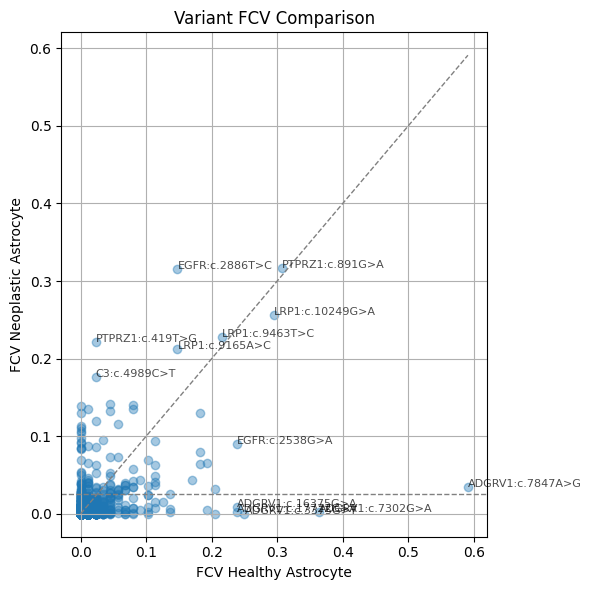

In [26]:
healthy_astrocyte_FCV_max = 1
neoplastic_astrocyte_FCV_min = 0.025

top_variants = set(adata.var.sort_values("FCV_neoplastic_astrocyte", ascending=False)['variant_name'].unique())
# top_variants = set(adata.var.sort_values("FCV_neoplastic_astrocyte", ascending=False).head(number_of_variants_to_select_heatmap)['variant_name'].unique())

# Filter the DataFrame for the top_variants
df_tmp = adata.var.loc[adata.var["variant_name"].isin(top_variants)]

# Create the scatterplot
plt.figure(figsize=(6, 6))
plt.scatter(
    df_tmp["FCV_healthy_astrocyte"],
    df_tmp["FCV_neoplastic_astrocyte"],
    alpha=0.4
)

# Add y = x reference line
lims = [
    min(df_tmp["FCV_healthy_astrocyte"].min(), df_tmp["FCV_neoplastic_astrocyte"].min()),
    max(df_tmp["FCV_healthy_astrocyte"].max(), df_tmp["FCV_neoplastic_astrocyte"].max())
]
plt.plot(lims, lims, color="gray", linestyle="--", linewidth=1)

# Label axes
plt.xlabel("FCV Healthy Astrocyte")
plt.ylabel("FCV Neoplastic Astrocyte")
plt.title("Variant FCV Comparison")

# Optionally annotate points
for _, row in df_tmp.iterrows():
    if (
        row["FCV_neoplastic_astrocyte"] > 0.16
        or row["FCV_healthy_astrocyte"] > 0.23
    ):
        plt.annotate(
            row["variant_name_with_gene_name_instead_of_transcript_id"],
            (row["FCV_healthy_astrocyte"], row["FCV_neoplastic_astrocyte"]),
            fontsize=8,
            alpha=0.7
        )

if healthy_astrocyte_FCV_max < 1:
    plt.axvline(
        x=healthy_astrocyte_FCV_max,
        color="gray",
        linestyle="--",
        linewidth=1,
    )

    plt.text(
        healthy_astrocyte_FCV_max,             # x position
        lims[1],                                # y position (top of the plot)
        f"Cancer-specific threshold", # label text
        va="bottom",
        ha="left",
        color="gray",
        fontsize=8
    )

plt.axhline(
    y=neoplastic_astrocyte_FCV_min,
    color="gray",
    linestyle="--",
    linewidth=1,
)

plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "FCV_neoplastic_astrocyte_vs_FCV_healthy_astrocyte.pdf"), bbox_inches="tight")
plt.show()


Choose variant_for_de_gene_only based on something in a sizable fraction of neoplastic astrocytes, and make a new column f"has_{variant_for_de}" in adata.obs

In [27]:
variant_for_de_gene_only = "C3:c.4989C>T"
variant_for_de = adata_astrocytes.var.loc[adata_astrocytes.var["variant_name_with_gene_name_instead_of_transcript_id"] == variant_for_de_gene_only, "variant_name"].values
assert len(variant_for_de) == 1, f"Expected one variant for {variant_for_de_gene_only}, got {len(variant_for_de)}"
variant_for_de = variant_for_de[0]

variant_for_de_colname = f"has_{variant_for_de}"
variant_idx = adata.var_names.get_loc(variant_for_de)
variant_counts = adata.X[:, variant_idx]

variant_counts = variant_counts.toarray().ravel() if hasattr(variant_counts, "toarray") else variant_counts.ravel()
adata.obs[variant_for_de_colname] = variant_counts > 0

# print(adata.obs.loc[adata.obs["cell_type_broad"] == "Neoplastic cells", colname].sum())

adata_reference_genome.obs = adata_reference_genome.obs.join(adata.obs[[variant_for_de_colname]], how='left')

In [28]:
t2g_df = pd.read_csv(
    t2g_file,
    sep="\t",
    header=None,
    usecols=[0, 1, 2],
    names=["transcript_id", "gene_id", "gene_symbol"]
)

gene_id_to_gene_symbol = t2g_df.drop_duplicates("gene_id").set_index("gene_id")["gene_symbol"]

In [29]:
adata_neoplastic = adata_reference_genome[adata_reference_genome.obs["cell_type_broad"] == "Neoplastic cells"].copy()
adata_neoplastic.obs[variant_for_de_colname] = adata_neoplastic.obs[variant_for_de_colname].map({True: variant_for_de_gene_only, False: "WT"}).astype("category")
print(adata_neoplastic.obs[variant_for_de_colname].value_counts())
adata_neoplastic.var["gene_symbol"] = (
    adata_neoplastic.var.index.map(gene_id_to_gene_symbol)
    .to_series(index=adata_neoplastic.var.index)
    .combine_first(pd.Series(adata_neoplastic.var.index, index=adata_neoplastic.var.index))
)

adata_neoplastic.var["gene_id"] = adata_neoplastic.var.index
adata_neoplastic.var_names = adata_neoplastic.var["gene_symbol"]

sc.pp.filter_genes(adata_neoplastic, min_cells=3)

sc.pp.normalize_total(adata_neoplastic, target_sum=1e6)
sc.pp.log1p(adata_neoplastic)

sc.tl.rank_genes_groups(
    adata_neoplastic,
    groupby=variant_for_de_colname,
    method="wilcoxon"          # Or "t-test", "logreg", etc.
)

has_ENST00000245907:c.4989C>T
WT              898
C3:c.4989C>T    193
Name: count, dtype: int64


Number of significant DE genes (FDR < 0.05): 2557
          group     names     scores  logfoldchanges         pvals  \
0  C3:c.4989C>T        C3  20.408707        9.013463  1.399366e-92   
1  C3:c.4989C>T    IFITM3  14.380018        4.392840  6.907651e-47   
2  C3:c.4989C>T       C1R  14.195446        4.848956  9.776275e-46   
3  C3:c.4989C>T      SOD2  14.065011        4.056407  6.231284e-45   
4  C3:c.4989C>T      CD44  13.296002        4.536346  2.441793e-40   
5  C3:c.4989C>T     NAMPT  12.941211        4.030876  2.634455e-38   
6  C3:c.4989C>T    IGFBP7  12.833817        4.550174  1.060111e-37   
7  C3:c.4989C>T    CHI3L1  12.754372        6.384045  2.947405e-37   
8  C3:c.4989C>T       C1S  12.283876        4.732575  1.105706e-34   
9  C3:c.4989C>T  SERPING1  12.166661        4.168031  4.678275e-34   

      pvals_adj  
0  4.334676e-88  
1  1.069857e-42  
2  1.009433e-41  
3  4.825507e-41  
4  1.512740e-36  
5  1.360081e-34  
6  4.691142e-34  
7  1.141235e-33  
8  3.805595e-31  

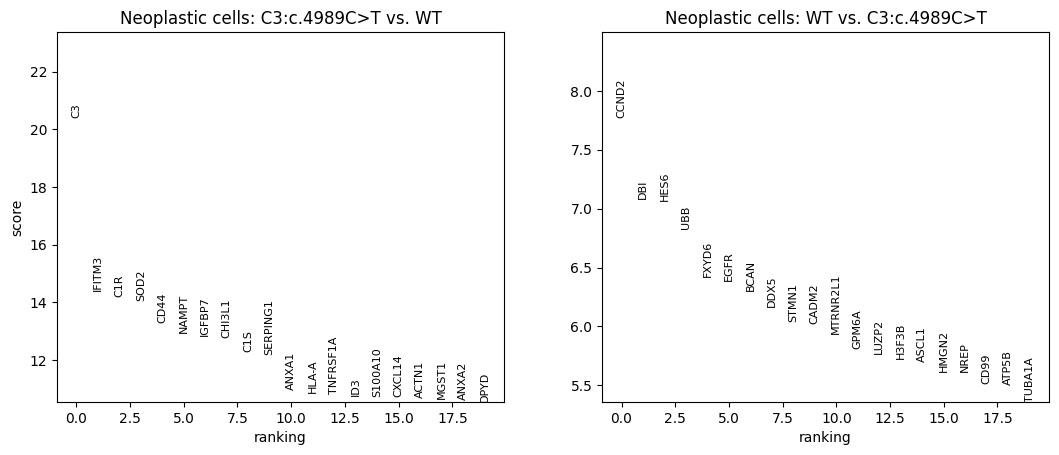

In [30]:
gene_of_interest = "C3"  # variant_for_de_gene_only.split(":")[0]

de_df = sc.get.rank_genes_groups_df(adata_neoplastic, group=None)
de_df = de_df.loc[de_df['group'] == variant_for_de_gene_only, :].copy()  # remove the double-counting
n_sig = (de_df["pvals_adj"] < 0.05).sum()
print(f"Number of significant DE genes (FDR < 0.05): {n_sig}")

print(de_df.sort_values("pvals_adj").head(10))

fig = sc.pl.rank_genes_groups(adata_neoplastic, n_genes=20, sharey=False, show=False)
fig = plt.gcf()
axes = fig.axes
axes[0].set_title(f"Neoplastic cells: {variant_for_de_gene_only} vs. WT")
axes[1].set_title(f"Neoplastic cells: WT vs. {variant_for_de_gene_only}")
variant_for_de_gene_only_title = variant_for_de_gene_only.replace(".", "_").replace(":", "_").replace(">", "_")
fig.savefig(os.path.join(out_dir, f"rank_genes_groups_neoplastic_astrocytes_{variant_for_de_gene_only_title}.pdf"), bbox_inches="tight")

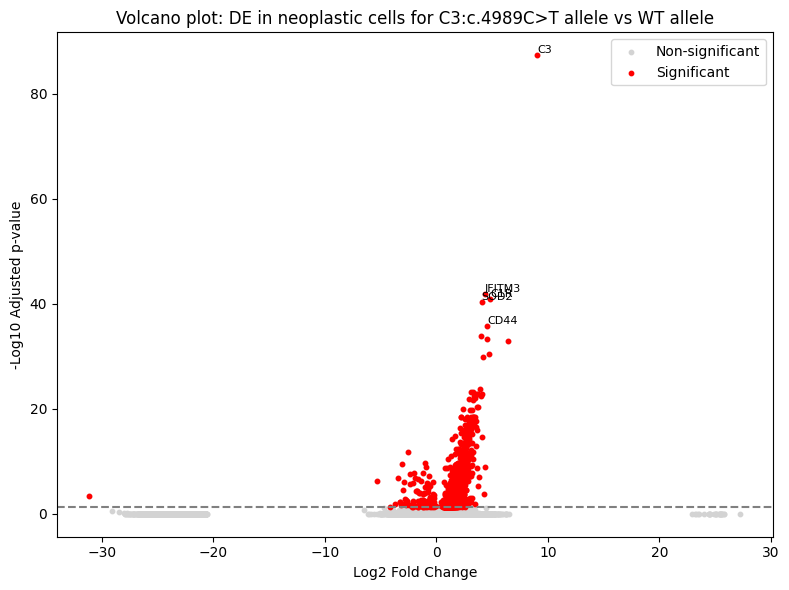

In [31]:
num_genes_to_label = 5

# For clarity, define which genes are significant
significance_threshold = 0.05
de_df["significant"] = de_df["pvals_adj"] < significance_threshold

# Start a figure
plt.figure(figsize=(8, 6))

# Plot all genes
plt.scatter(
    de_df["logfoldchanges"],
    -np.log10(de_df["pvals_adj"]),
    c="lightgrey",
    s=10,
    label="Non-significant"
)

# Highlight significant genes
plt.scatter(
    de_df.loc[de_df["significant"], "logfoldchanges"],
    -np.log10(de_df.loc[de_df["significant"], "pvals_adj"]),
    c="red",
    s=10,
    label="Significant"
)

# Add horizontal significance threshold line
plt.axhline(-np.log10(significance_threshold), color="grey", linestyle="--")

# Add labels for top 20 positive logFC genes
de_df_pos_fc = de_df[de_df["logfoldchanges"] > 0]
top_genes = de_df_pos_fc.nsmallest(num_genes_to_label, "pvals_adj")
for _, row in top_genes.iterrows():
    plt.text(
        row["logfoldchanges"],
        -np.log10(row["pvals_adj"]),
        row["names"],
        fontsize=8,
        ha="left",
        va="bottom"
    )

# Labels
plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10 Adjusted p-value")
plt.title(f"Volcano plot: DE in neoplastic cells for {variant_for_de_gene_only} allele vs WT allele")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(out_dir, f"volcano_plot_neoplastic_astrocytes_{variant_for_de_gene_only_title}.pdf"), bbox_inches="tight")
plt.show()


## Call it cancer-specific if it's in a bigger fraction of neoplastic astrocytes than healthy astrocytes AND it's in a small fraction of healthy astrocytes (healthy_astrocyte_FCV_max) AND it's in a decent fraction of neoplastic astrocytes (neoplastic_astrocyte_FCV_min)

In [32]:
adata.var["cancer_specific"] = (
    (adata.var["FCV_healthy_astrocyte"] < adata.var["FCV_neoplastic_astrocyte"])
    # &
    # (adata.var["FCV_healthy_astrocyte"] <= healthy_astrocyte_FCV_max)
    &
    (adata.var["FCV_neoplastic_astrocyte"] >= neoplastic_astrocyte_FCV_min)
)

adata_astrocytes.var["cancer_specific"] = (
    (adata_astrocytes.var["FCV_healthy_astrocyte"] < adata_astrocytes.var["FCV_neoplastic_astrocyte"])
    # &
    # (adata_astrocytes.var["FCV_healthy_astrocyte"] <= healthy_astrocyte_FCV_max)
    &
    (adata_astrocytes.var["FCV_neoplastic_astrocyte"] >= neoplastic_astrocyte_FCV_min)
)

In [33]:
# Make the boolean column
adata_astrocytes.var["cbio_gene"] = adata_astrocytes.var["gene_symbol"].isin(gbm_genes)

# Counts of True in `cancer_specific`
n_cancer_specific_total = adata_astrocytes.var["cancer_specific"].sum()

# Counts of True in `cancer_specific` **restricted to cbio genes**
n_cancer_specific_cbio = adata_astrocytes.var.loc[
    adata_astrocytes.var["cbio_gene"], "cancer_specific"
].sum()

print(f"cancer_specific == True (all genes): {n_cancer_specific_total}")
print(f"cancer_specific == True (cbio_gene == True): {n_cancer_specific_cbio}")

cancer_specific == True (all genes): 73
cancer_specific == True (cbio_gene == True): 73


In [34]:
adata_astrocytes.var.head()

,variant_name,gene_symbol,variant_count,gene_count,number_obs,FCV,ROLE_IN_CANCER,TUMOUR_TYPES_SOMATIC,TUMOUR_TYPES_GERMLINE,seq_ID,mutation_cdna,nucleotide_positions,actual_variant,start_variant_position,end_variant_position,gene_id,variant_name_with_gene_id,variant_name_with_gene_name_instead_of_transcript_id,variant_name_with_gene_name,number_obs_neoplastic_astrocyte,number_obs_healthy_astrocyte,FCV_neoplastic_astrocyte,FCV_healthy_astrocyte,FCV_neoplastic_astrocyte_to_FCV_healthy_astrocyte_ratio,cancer_specific,cbio_gene
variant,,,,,,,,,,,,,,,,,,,,,,,,,,
ENST00000256646:c.847C>T,ENST00000256646:c.847C>T,NOTCH2,2.0,189,1,0.000279,"oncogene, TSG","marginal zone lymphoma, DLBCL, bladder",NaN,ENST00000256646,c.847C>T,847,C>T,847.0,847.0,ENSG00000134250,ENSG00000134250(ENST00000256646):c.847C>T,NOTCH2:c.847C>T,NOTCH2(ENST00000256646):c.847C>T,0,0,0.000000,0.0,NaN,False,True
ENST00000256646:c.7169C>T,ENST00000256646:c.7169C>T,NOTCH2,3.0,189,1,0.000279,"oncogene, TSG","marginal zone lymphoma, DLBCL, bladder",NaN,ENST00000256646,c.7169C>T,7169,C>T,7169.0,7169.0,ENSG00000134250,ENSG00000134250(ENST00000256646):c.7169C>T,NOTCH2:c.7169C>T,NOTCH2(ENST00000256646):c.7169C>T,1,0,0.000917,0.0,inf,False,True
ENST00000256646:c.6314C>T,ENST00000256646:c.6314C>T,NOTCH2,2.0,189,1,0.000279,"oncogene, TSG","marginal zone lymphoma, DLBCL, bladder",NaN,ENST00000256646,c.6314C>T,6314,C>T,6314.0,6314.0,ENSG00000134250,ENSG00000134250(ENST00000256646):c.6314C>T,NOTCH2:c.6314C>T,NOTCH2(ENST00000256646):c.6314C>T,0,0,0.000000,0.0,NaN,False,True
ENST00000256646:c.5768G>A,ENST00000256646:c.5768G>A,NOTCH2,2.0,189,1,0.000279,"oncogene, TSG","marginal zone lymphoma, DLBCL, bladder",NaN,ENST00000256646,c.5768G>A,5768,G>A,5768.0,5768.0,ENSG00000134250,ENSG00000134250(ENST00000256646):c.5768G>A,NOTCH2:c.5768G>A,NOTCH2(ENST00000256646):c.5768G>A,1,0,0.000917,0.0,inf,False,True
ENST00000256646:c.634A>T,ENST00000256646:c.634A>T,NOTCH2,6.0,189,3,0.000836,"oncogene, TSG","marginal zone lymphoma, DLBCL, bladder",NaN,ENST00000256646,c.634A>T,634,A>T,634.0,634.0,ENSG00000134250,ENSG00000134250(ENST00000256646):c.634A>T,NOTCH2:c.634A>T,NOTCH2(ENST00000256646):c.634A>T,0,0,0.000000,0.0,NaN,False,True


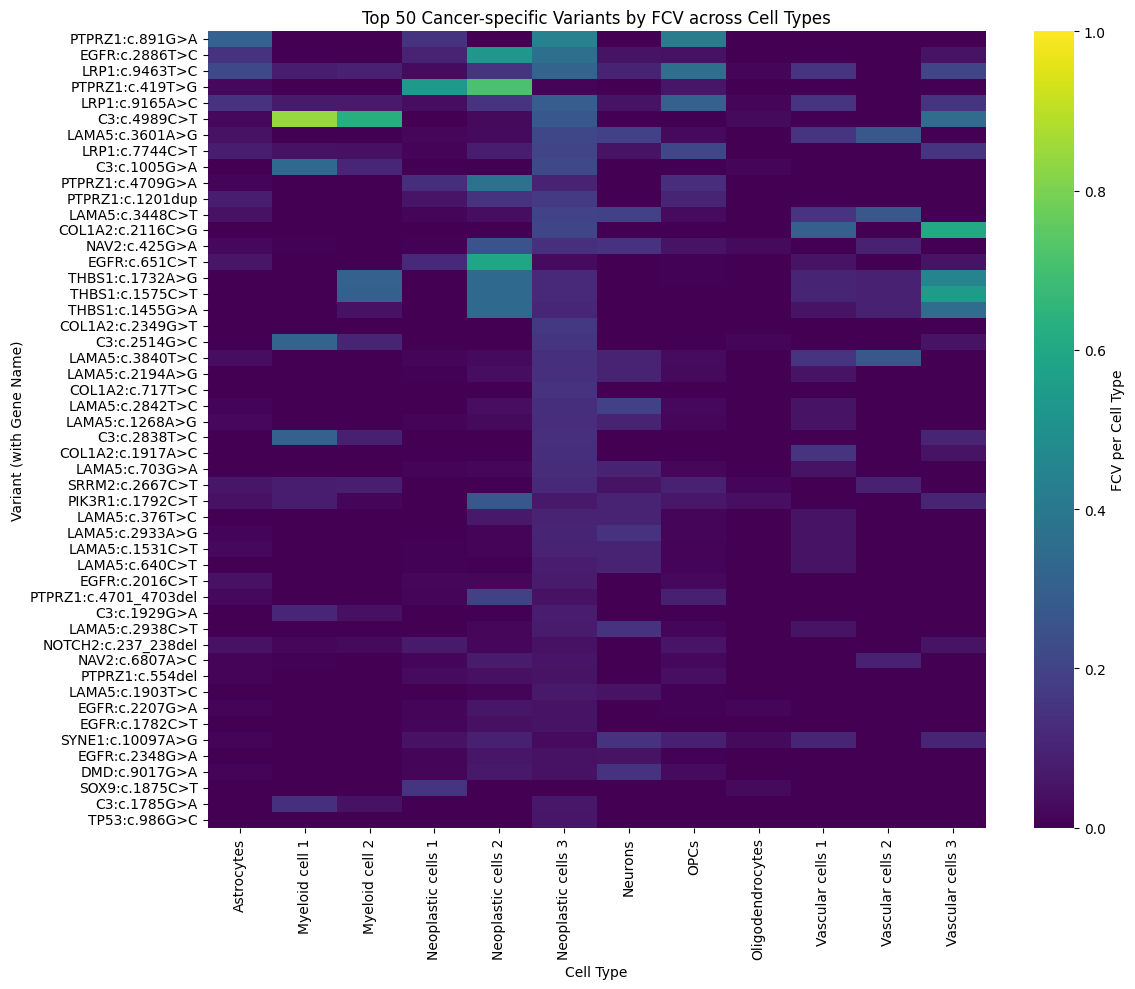

In [35]:
number_of_variants_to_select_heatmap = 50

# 1. Select top 100 cancer-specific variants by neoplastic astrocyte FCV
top_variant_indices = (
    adata.var.loc[adata.var["cancer_specific"]]
    .sort_values("FCV_neoplastic_astrocyte", ascending=False)
    .head(number_of_variants_to_select_heatmap)
    .index
)

# 2. Subset the data to those variants
adata_top = adata[:, top_variant_indices].copy()

X_dense = adata_top.X.toarray() if hasattr(adata_top.X, "toarray") else adata_top.X

# Get variant names in original order
variant_names = adata_top.var["variant_name_with_gene_name_instead_of_transcript_id"]

# Get cell types for each cell
cell_types = adata_top.obs["cell_type"]

# Create DataFrame: rows = cells, columns = variants
cell_variant_df = pd.DataFrame(X_dense, columns=variant_names)
cell_variant_df["cell_type"] = cell_types.values

# Melt and filter to nonzero entries (variant detected in a cell)
melted = cell_variant_df.melt(id_vars="cell_type", var_name="variant", value_name="count")
melted = melted[melted["count"] > 0]

# Count number of cells per variant per cell type
raw_counts = melted.groupby(["variant", "cell_type"]).size().unstack(fill_value=0)

# Normalize by number of cells of each type
cell_type_counts_all = cell_types.value_counts()
heatmap_df = raw_counts / cell_type_counts_all

# Reorder rows to match original variant order
heatmap_df = heatmap_df.reindex(variant_names.values, axis=0)

# # 3. Make a DataFrame with average FCV per cell type
# # Make sure adata.X is dense; convert if sparse
# X_dense = adata_top.X.toarray() if hasattr(adata_top.X, "toarray") else adata_top.X

# # Build DataFrame: rows = cells, columns = variants
# df = pd.DataFrame(X_dense, columns=adata_top.var["variant_name_with_gene_name"], index=adata_top.obs["cell_type"])

# # Group by cell_type and take mean FCV
# heatmap_df = df.groupby(level=0).mean().T  # transpose to get variants as rows, cell_types as columns

# 4. Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_df, cmap="viridis", vmin=0, vmax=1, xticklabels=True, yticklabels=True, cbar_kws={"label": "FCV per Cell Type"})
plt.xlabel("Cell Type")
plt.ylabel("Variant (with Gene Name)")
plt.title(f"Top {number_of_variants_to_select_heatmap} Cancer-specific Variants by FCV across Cell Types")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "heatmap_top_variants_by_FCV.pdf"), bbox_inches='tight')
plt.show()

## Back

### Count number of mutations in each gene

In [36]:
# Create mask: keep rows where at least one of the counts is > 0
mask = ~((adata_astrocytes.var["number_obs_neoplastic_astrocyte"] == 0) & 
         (adata_astrocytes.var["number_obs_healthy_astrocyte"] == 0))

# Apply to get a filtered copy
adata_astrocytes_filtered = adata_astrocytes[:, mask].copy()

In [37]:
adata_astrocytes_filtered.obs.head()

,Run,experiment_name,cell_type_sra,neoplastic,Patient_ID,tissue,tsne_cluster,cell_type,cell_type_broad
barcode,,,,,,,,,
AAAAAAAAAAAAAAAA,SRR3934349,1001000173.G8,Neoplastic,Neoplastic,BT_S2,Tumor,11,Neoplastic cells 3,Neoplastic cells
AAAAAAAAAAAAAAAG,SRR3934351,1001000173.B4,Neoplastic,Neoplastic,BT_S2,Tumor,11,Neoplastic cells 3,Neoplastic cells
AAAAAAAAAAAAAAAT,SRR3934352,1001000173.A2,Neoplastic,Neoplastic,BT_S2,Tumor,11,Neoplastic cells 3,Neoplastic cells
AAAAAAAAAAAAAACA,SRR3934353,1001000173.E2,Neoplastic,Neoplastic,BT_S2,Tumor,11,Neoplastic cells 3,Neoplastic cells
AAAAAAAAAAAAAACC,SRR3934354,1001000173.F6,Neoplastic,Neoplastic,BT_S2,Tumor,11,Neoplastic cells 3,Neoplastic cells


Number of COSMIC mutations: 1179
Number of genes: 167


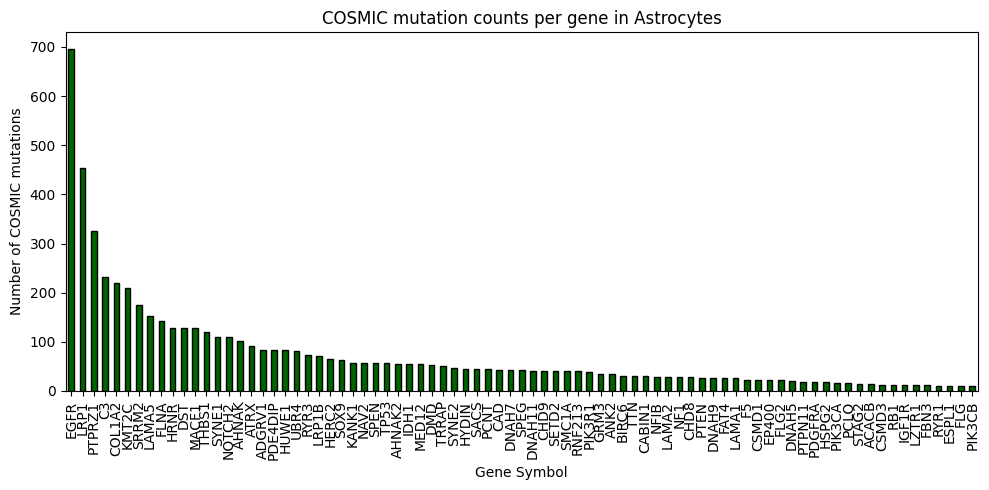

In [38]:
gene_counts = adata_astrocytes_filtered.var["gene_symbol"].value_counts()

print(f"Number of COSMIC mutations: {len(adata_astrocytes_filtered)}")
print(f"Number of genes: {len(adata_astrocytes_filtered.var['gene_symbol'].unique())}")


plt.figure(figsize=(10, 5))
gene_counts_filtered = gene_counts[gene_counts > 10]
gene_counts_filtered.plot(kind="bar", color="darkgreen", edgecolor="black")

plt.ylabel("Number of COSMIC mutations")
plt.xlabel("Gene Symbol")
plt.title("COSMIC mutation counts per gene in Astrocytes")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Number of COSMIC mutations: 88
Number of genes: 92


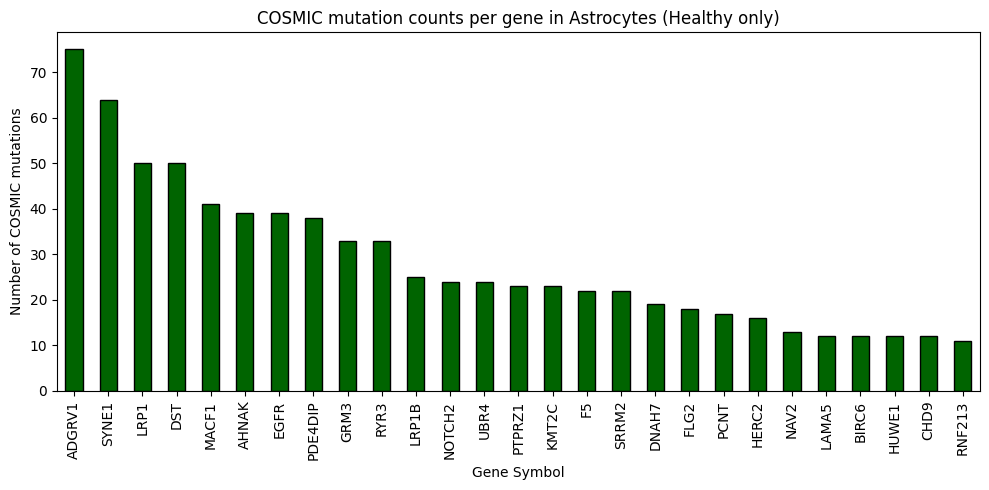

In [39]:
# repeat of above but just for healthy
adata_astrocytes_filtered_healthy_only = adata_astrocytes_filtered[adata_astrocytes_filtered.obs['cell_type_broad'] == "Astrocytes"].copy()

# Create mask: keep rows where at least one of the counts is > 0
mask = ~(adata_astrocytes_filtered_healthy_only.var["number_obs_healthy_astrocyte"] == 0)
adata_astrocytes_filtered_healthy_only = adata_astrocytes_filtered_healthy_only[:, mask].copy()

gene_counts_heatlhy_astrocyte_only = adata_astrocytes_filtered_healthy_only.var["gene_symbol"].value_counts()
print(f"Number of COSMIC mutations: {len(adata_astrocytes_filtered_healthy_only)}")
print(f"Number of genes: {len(adata_astrocytes_filtered_healthy_only.var['gene_symbol'].unique())}")


plt.figure(figsize=(10, 5))
gene_counts_filtered_healthy_astrocyte_only = gene_counts_heatlhy_astrocyte_only[gene_counts_heatlhy_astrocyte_only > 10]
gene_counts_filtered_healthy_astrocyte_only.plot(kind="bar", color="darkgreen", edgecolor="black")

plt.ylabel("Number of COSMIC mutations")
plt.xlabel("Gene Symbol")
plt.title("COSMIC mutation counts per gene in Astrocytes (Healthy only)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [40]:
# adata_astrocytes_filtered.var.loc[adata_astrocytes_filtered.var['cancer_specific']].sort_values(by="FCV_neoplastic_astrocyte", ascending=False).to_csv(os.path.join(out_dir, "Astrocytes_filtered.csv"), sep="\t")
adata_astrocytes_filtered.var.loc[adata_astrocytes_filtered.var['cancer_specific']].sort_values(by="FCV_neoplastic_astrocyte", ascending=False).head(100)

,variant_name,gene_symbol,variant_count,gene_count,number_obs,FCV,ROLE_IN_CANCER,TUMOUR_TYPES_SOMATIC,TUMOUR_TYPES_GERMLINE,seq_ID,mutation_cdna,nucleotide_positions,actual_variant,start_variant_position,end_variant_position,gene_id,variant_name_with_gene_id,variant_name_with_gene_name_instead_of_transcript_id,variant_name_with_gene_name,number_obs_neoplastic_astrocyte,number_obs_healthy_astrocyte,FCV_neoplastic_astrocyte,FCV_healthy_astrocyte,FCV_neoplastic_astrocyte_to_FCV_healthy_astrocyte_ratio,cancer_specific,cbio_gene
variant,,,,,,,,,,,,,,,,,,,,,,,,,,
ENST00000393386:c.891G>A,ENST00000393386:c.891G>A,PTPRZ1,13364.0,427,541,0.150738,NaN,NaN,NaN,ENST00000393386,c.891G>A,891,G>A,891.0,891.0,ENSG00000106278,ENSG00000106278(ENST00000393386):c.891G>A,PTPRZ1:c.891G>A,PTPRZ1(ENST00000393386):c.891G>A,346,27,0.317140,0.306818,1.033642,True,True
ENST00000275493:c.2886T>C,ENST00000275493:c.2886T>C,EGFR,11074.0,703,378,0.105322,oncogene,"glioma, NSCLC",NSCLC,ENST00000275493,c.2886T>C,2886,T>C,2886.0,2886.0,ENSG00000146648,ENSG00000146648(ENST00000275493):c.2886T>C,EGFR:c.2886T>C,EGFR(ENST00000275493):c.2886T>C,344,13,0.315307,0.147727,2.134386,True,True
ENST00000243077:c.9463T>C,ENST00000243077:c.9463T>C,LRP1,22205.0,705,588,0.163834,NaN,NaN,NaN,ENST00000243077,c.9463T>C,9463,T>C,9463.0,9463.0,ENSG00000123384,ENSG00000123384(ENST00000243077):c.9463T>C,LRP1:c.9463T>C,LRP1(ENST00000243077):c.9463T>C,249,19,0.228231,0.215909,1.057070,True,True
ENST00000393386:c.419T>G,ENST00000393386:c.419T>G,PTPRZ1,10327.0,427,266,0.074115,NaN,NaN,NaN,ENST00000393386,c.419T>G,419,T>G,419.0,419.0,ENSG00000106278,ENSG00000106278(ENST00000393386):c.419T>G,PTPRZ1:c.419T>G,PTPRZ1(ENST00000393386):c.419T>G,241,2,0.220898,0.022727,9.719523,True,True
ENST00000243077:c.9165A>C,ENST00000243077:c.9165A>C,LRP1,14901.0,705,501,0.139593,NaN,NaN,NaN,ENST00000243077,c.9165A>C,9165,A>C,9165.0,9165.0,ENSG00000123384,ENSG00000123384(ENST00000243077):c.9165A>C,LRP1:c.9165A>C,LRP1(ENST00000243077):c.9165A>C,231,13,0.211732,0.147727,1.433265,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENST00000262189:c.8259G>A,ENST00000262189:c.8259G>A,KMT2C,941.0,402,53,0.014767,TSG,medulloblastoma,NaN,ENST00000262189,c.8259G>A,8259,G>A,8259.0,8259.0,ENSG00000055609,ENSG00000055609(ENST00000262189):c.8259G>A,KMT2C:c.8259G>A,KMT2C(ENST00000262189):c.8259G>A,29,2,0.026581,0.022727,1.169569,True,True
ENST00000393386:c.4561G>A,ENST00000393386:c.4561G>A,PTPRZ1,611.0,427,29,0.00808,NaN,NaN,NaN,ENST00000393386,c.4561G>A,4561,G>A,4561.0,4561.0,ENSG00000106278,ENSG00000106278(ENST00000393386):c.4561G>A,PTPRZ1:c.4561G>A,PTPRZ1(ENST00000393386):c.4561G>A,29,0,0.026581,0.000000,inf,True,True
ENST00000382303:c.3354A>G,ENST00000382303:c.3354A>G,KANK1,758.0,91,69,0.019225,NaN,NaN,NaN,ENST00000382303,c.3354A>G,3354,A>G,3354.0,3354.0,ENSG00000107104,ENSG00000107104(ENST00000382303):c.3354A>G,KANK1:c.3354A>G,KANK1(ENST00000382303):c.3354A>G,28,0,0.025665,0.000000,inf,True,True


In [41]:
adata_astrocytes_filtered.var.loc[(adata_astrocytes_filtered.var["gene_symbol"].isin(["EGFR", "SOX9"])) & (adata_astrocytes_filtered.var['cancer_specific'])].sort_values(by="FCV_neoplastic_astrocyte", ascending=False).head(100)

,variant_name,gene_symbol,variant_count,gene_count,number_obs,FCV,ROLE_IN_CANCER,TUMOUR_TYPES_SOMATIC,TUMOUR_TYPES_GERMLINE,seq_ID,mutation_cdna,nucleotide_positions,actual_variant,start_variant_position,end_variant_position,gene_id,variant_name_with_gene_id,variant_name_with_gene_name_instead_of_transcript_id,variant_name_with_gene_name,number_obs_neoplastic_astrocyte,number_obs_healthy_astrocyte,FCV_neoplastic_astrocyte,FCV_healthy_astrocyte,FCV_neoplastic_astrocyte_to_FCV_healthy_astrocyte_ratio,cancer_specific,cbio_gene
variant,,,,,,,,,,,,,,,,,,,,,,,,,,
ENST00000275493:c.2886T>C,ENST00000275493:c.2886T>C,EGFR,11074.0,703,378,0.105322,oncogene,"glioma, NSCLC",NSCLC,ENST00000275493,c.2886T>C,2886,T>C,2886.0,2886.0,ENSG00000146648,ENSG00000146648(ENST00000275493):c.2886T>C,EGFR:c.2886T>C,EGFR(ENST00000275493):c.2886T>C,344,13,0.315307,0.147727,2.134386,True,True
ENST00000275493:c.651C>T,ENST00000275493:c.651C>T,EGFR,4348.0,703,135,0.037615,oncogene,"glioma, NSCLC",NSCLC,ENST00000275493,c.651C>T,651,C>T,651.0,651.0,ENSG00000146648,ENSG00000146648(ENST00000275493):c.651C>T,EGFR:c.651C>T,EGFR(ENST00000275493):c.651C>T,126,5,0.115490,0.056818,2.032631,True,True
ENST00000275493:c.2016C>T,ENST00000275493:c.2016C>T,EGFR,1900.0,703,71,0.019783,oncogene,"glioma, NSCLC",NSCLC,ENST00000275493,c.2016C>T,2016,C>T,2016.0,2016.0,ENSG00000146648,ENSG00000146648(ENST00000275493):c.2016C>T,EGFR:c.2016C>T,EGFR(ENST00000275493):c.2016C>T,58,4,0.053162,0.045455,1.169569,True,True
ENST00000275493:c.2207G>A,ENST00000275493:c.2207G>A,EGFR,151.0,703,49,0.013653,oncogene,"glioma, NSCLC",NSCLC,ENST00000275493,c.2207G>A,2207,G>A,2207.0,2207.0,ENSG00000146648,ENSG00000146648(ENST00000275493):c.2207G>A,EGFR:c.2207G>A,EGFR(ENST00000275493):c.2207G>A,45,1,0.041247,0.011364,3.629698,True,True
ENST00000275493:c.1782C>T,ENST00000275493:c.1782C>T,EGFR,157.0,703,45,0.012538,oncogene,"glioma, NSCLC",NSCLC,ENST00000275493,c.1782C>T,1782,C>T,1782.0,1782.0,ENSG00000146648,ENSG00000146648(ENST00000275493):c.1782C>T,EGFR:c.1782C>T,EGFR(ENST00000275493):c.1782C>T,44,0,0.040330,0.000000,inf,True,True
ENST00000275493:c.2348G>A,ENST00000275493:c.2348G>A,EGFR,129.0,703,47,0.013096,oncogene,"glioma, NSCLC",NSCLC,ENST00000275493,c.2348G>A,2348,G>A,2348.0,2348.0,ENSG00000146648,ENSG00000146648(ENST00000275493):c.2348G>A,EGFR:c.2348G>A,EGFR(ENST00000275493):c.2348G>A,43,0,0.039413,0.000000,inf,True,True
ENST00000245479:c.1875C>T,ENST00000245479:c.1875C>T,SOX9,821.0,69,44,0.01226,NaN,NaN,NaN,ENST00000245479,c.1875C>T,1875,C>T,1875.0,1875.0,ENSG00000125398,ENSG00000125398(ENST00000245479):c.1875C>T,SOX9:c.1875C>T,SOX9(ENST00000245479):c.1875C>T,42,0,0.038497,0.000000,inf,True,True
ENST00000275493:c.1608G>A,ENST00000275493:c.1608G>A,EGFR,539.0,703,37,0.010309,oncogene,"glioma, NSCLC",NSCLC,ENST00000275493,c.1608G>A,1608,G>A,1608.0,1608.0,ENSG00000146648,ENSG00000146648(ENST00000275493):c.1608G>A,EGFR:c.1608G>A,EGFR(ENST00000275493):c.1608G>A,36,0,0.032997,0.000000,inf,True,True
ENST00000275493:c.2557C>T,ENST00000275493:c.2557C>T,EGFR,132.0,703,33,0.009195,oncogene,"glioma, NSCLC",NSCLC,ENST00000275493,c.2557C>T,2557,C>T,2557.0,2557.0,ENSG00000146648,ENSG00000146648(ENST00000275493):c.2557C>T,EGFR:c.2557C>T,EGFR(ENST00000275493):c.2557C>T,33,0,0.030247,0.000000,inf,True,True


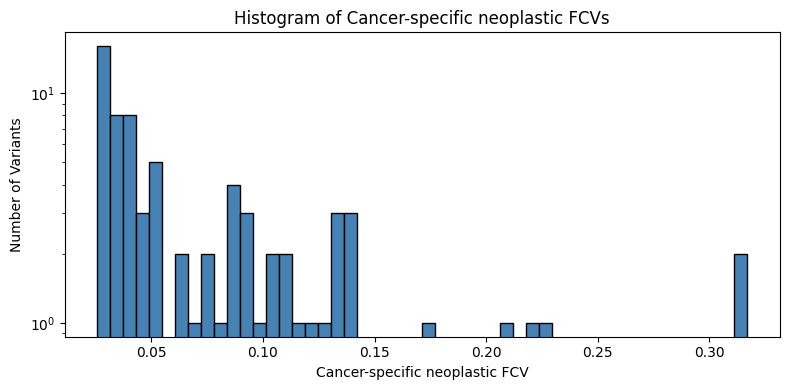

In [42]:
histogram_values = adata_astrocytes_filtered.var.loc[adata_astrocytes_filtered.var['cancer_specific'], "FCV_neoplastic_astrocyte"].dropna().values

plt.figure(figsize=(8, 4))
plt.hist(histogram_values, bins=50, color='steelblue', edgecolor='black')
plt.xlabel("Cancer-specific neoplastic FCV")
plt.ylabel("Number of Variants")
# plt.xscale('log')
plt.yscale('log')
plt.title("Histogram of Cancer-specific neoplastic FCVs")
plt.tight_layout()
plt.show()

In [43]:
print(f"EGFR/SOX9 = {gene_counts['EGFR']}/{gene_counts['SOX9']} = {gene_counts['EGFR'] / gene_counts['SOX9']:.2f}")

EGFR/SOX9 = 695/64 = 10.86


More than the 2.4 represented in COSMIC

## Total mutational burden in astrocytes

# Histograms

In [44]:
adata.obs.head()

,Run,experiment_name,cell_type_sra,neoplastic,Patient_ID,tissue,tsne_cluster,cell_type,cell_type_broad,has_ENST00000245907:c.4989C>T
barcode,,,,,,,,,,
AAAAAAAAAAAAAAAA,SRR3934349,1001000173.G8,Neoplastic,Neoplastic,BT_S2,Tumor,11,Neoplastic cells 3,Neoplastic cells,False
AAAAAAAAAAAAAAAC,SRR3934350,1001000173.D4,Oligodendrocyte,Regular,BT_S2,Tumor,2,Oligodendrocytes,Oligodendrocytes,False
AAAAAAAAAAAAAAAG,SRR3934351,1001000173.B4,Neoplastic,Neoplastic,BT_S2,Tumor,11,Neoplastic cells 3,Neoplastic cells,True
AAAAAAAAAAAAAAAT,SRR3934352,1001000173.A2,Neoplastic,Neoplastic,BT_S2,Tumor,11,Neoplastic cells 3,Neoplastic cells,False
AAAAAAAAAAAAAACA,SRR3934353,1001000173.E2,Neoplastic,Neoplastic,BT_S2,Tumor,11,Neoplastic cells 3,Neoplastic cells,False


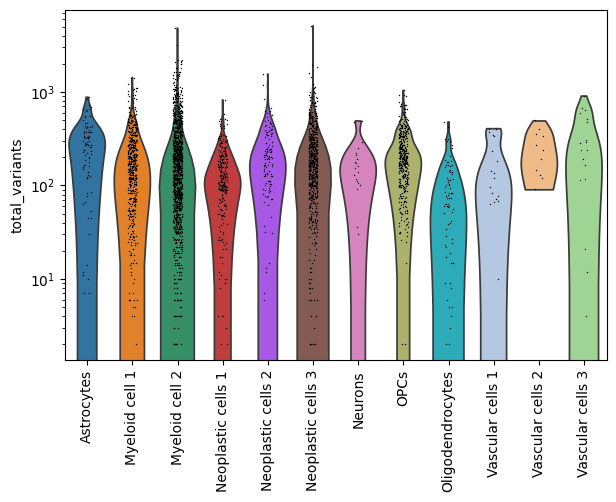

In [45]:
total_variants = adata.X.sum(axis=1).A1 if hasattr(adata.X, "A1") else np.ravel(adata.X.sum(axis=1))
adata.obs["total_variants"] = total_variants
sc.pl.violin(adata, keys='total_variants', groupby='cell_type', rotation=90, log=True)

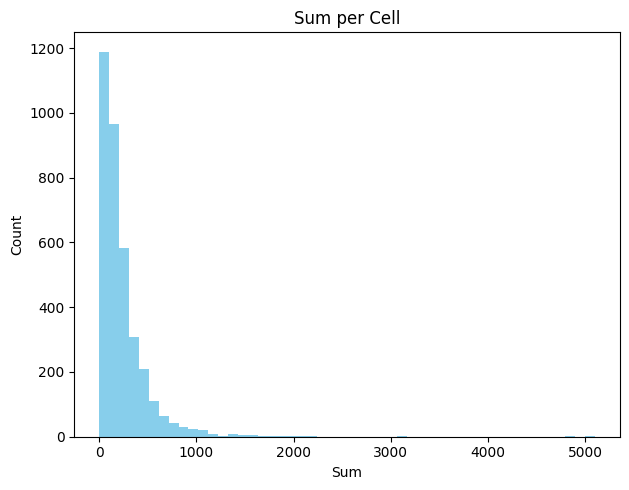

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Sum across rows (total variant counts per cell)
row_sums = adata.X.sum(axis=1).A1 if hasattr(adata.X, "A1") else np.ravel(adata.X.sum(axis=1))

# Sum across columns (total counts across all cells per variant)
col_sums = adata.X.sum(axis=0).A1 if hasattr(adata.X, "A1") else np.ravel(adata.X.sum(axis=0))

# Plot histograms
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(row_sums, bins=50, color='skyblue')
plt.title('Sum per Cell')
plt.xlabel('Sum')
plt.ylabel('Count')

# plt.subplot(1, 2, 2)
# plt.hist(col_sums, bins=50, color='salmon')
# plt.title('Sum per Gene')
# plt.xlabel('Sum')
# plt.ylabel('Count')

plt.tight_layout()
plt.show()


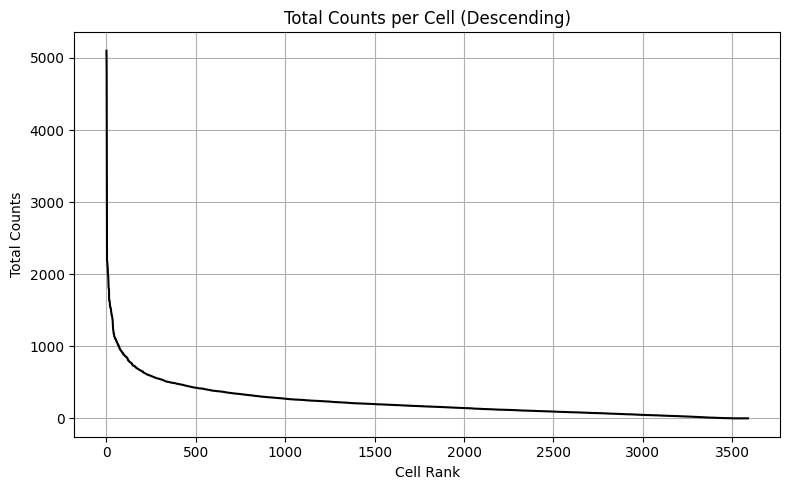

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Compute sum per cell (rows)
row_sums = adata.X.sum(axis=1).A1 if hasattr(adata.X, "A1") else np.ravel(adata.X.sum(axis=1))

# Sort descending
sorted_sums = np.sort(row_sums)[::-1]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(sorted_sums, color='black')
plt.title("Total Counts per Cell (Descending)")
plt.xlabel("Cell Rank")
plt.ylabel("Total Counts")
plt.grid(True)
plt.tight_layout()
plt.show()


## assign oncogene vs tumor suppressor gene - I expect oncogenes to be more prevelant in mutation data

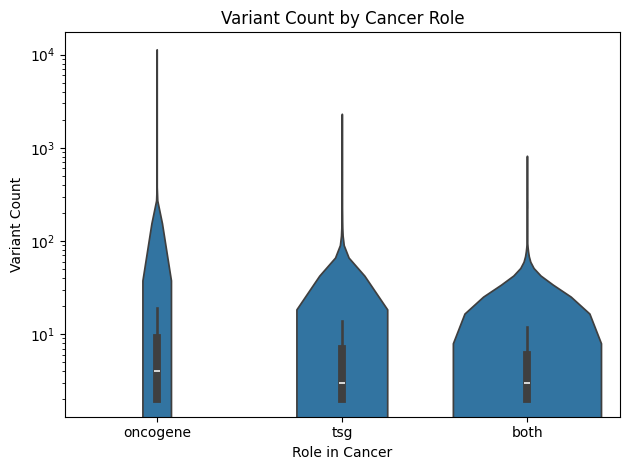

In [48]:
# Copy the column and drop NaNs
role = adata.var['ROLE_IN_CANCER'].dropna().copy()

# Map to simplified categories
def simplify_role(val):
    val = val.lower()
    if 'oncogene' in val and 'tsg' in val:
        return 'both'
    elif 'oncogene' in val:
        return 'oncogene'
    elif 'tsg' in val:
        return 'tsg'
    else:
        return None  # optional: keep only known roles

adata.var['simplified_role'] = role.apply(simplify_role)
tumor_role_df = adata.var.dropna(subset=['simplified_role', 'variant_count'])

sns.violinplot(data=tumor_role_df, x='simplified_role', y='variant_count', order=['oncogene', 'tsg', 'both'])
plt.xlabel("Role in Cancer")
plt.ylabel("Variant Count")
plt.yscale('log')
plt.title("Variant Count by Cancer Role")
plt.tight_layout()
plt.show()


In [49]:
adata.var.head()

,variant_name,gene_symbol,variant_count,gene_count,number_obs,FCV,ROLE_IN_CANCER,TUMOUR_TYPES_SOMATIC,TUMOUR_TYPES_GERMLINE,seq_ID,mutation_cdna,nucleotide_positions,actual_variant,start_variant_position,end_variant_position,gene_id,variant_name_with_gene_id,variant_name_with_gene_name_instead_of_transcript_id,variant_name_with_gene_name,FCV_neoplastic_astrocyte,FCV_healthy_astrocyte,cancer_specific,simplified_role
variant,,,,,,,,,,,,,,,,,,,,,,,
ENST00000256646:c.847C>T,ENST00000256646:c.847C>T,NOTCH2,2.0,189,1,0.000279,"oncogene, TSG","marginal zone lymphoma, DLBCL, bladder",NaN,ENST00000256646,c.847C>T,847,C>T,847.0,847.0,ENSG00000134250,ENSG00000134250(ENST00000256646):c.847C>T,NOTCH2:c.847C>T,NOTCH2(ENST00000256646):c.847C>T,0.000000,0.0,False,both
ENST00000256646:c.7169C>T,ENST00000256646:c.7169C>T,NOTCH2,3.0,189,1,0.000279,"oncogene, TSG","marginal zone lymphoma, DLBCL, bladder",NaN,ENST00000256646,c.7169C>T,7169,C>T,7169.0,7169.0,ENSG00000134250,ENSG00000134250(ENST00000256646):c.7169C>T,NOTCH2:c.7169C>T,NOTCH2(ENST00000256646):c.7169C>T,0.000917,0.0,False,both
ENST00000256646:c.6314C>T,ENST00000256646:c.6314C>T,NOTCH2,2.0,189,1,0.000279,"oncogene, TSG","marginal zone lymphoma, DLBCL, bladder",NaN,ENST00000256646,c.6314C>T,6314,C>T,6314.0,6314.0,ENSG00000134250,ENSG00000134250(ENST00000256646):c.6314C>T,NOTCH2:c.6314C>T,NOTCH2(ENST00000256646):c.6314C>T,0.000000,0.0,False,both
ENST00000256646:c.5768G>A,ENST00000256646:c.5768G>A,NOTCH2,2.0,189,1,0.000279,"oncogene, TSG","marginal zone lymphoma, DLBCL, bladder",NaN,ENST00000256646,c.5768G>A,5768,G>A,5768.0,5768.0,ENSG00000134250,ENSG00000134250(ENST00000256646):c.5768G>A,NOTCH2:c.5768G>A,NOTCH2(ENST00000256646):c.5768G>A,0.000917,0.0,False,both
ENST00000256646:c.634A>T,ENST00000256646:c.634A>T,NOTCH2,6.0,189,3,0.000836,"oncogene, TSG","marginal zone lymphoma, DLBCL, bladder",NaN,ENST00000256646,c.634A>T,634,A>T,634.0,634.0,ENSG00000134250,ENSG00000134250(ENST00000256646):c.634A>T,NOTCH2:c.634A>T,NOTCH2(ENST00000256646):c.634A>T,0.000000,0.0,False,both


## Alphafold

### Let's hand-pick some of the top mutations
- ENST00000245907:c.1005G>A  # C3 - 151 neoplastic, 0 healthy
- ENST00000297268:c.2116C>G  # COL1A2 - 142 neoplastic, 0 healthy
- ENST00000260356:c.1732A>G  # THBS1 - 123 neoplastic, 0 healthy
- ENST00000260356:c.1575C>T  # THBS1 - 121 neoplastic, 0 healthy
- ENST00000297268:c.2349G>T  # COL1A2 - 114 neoplastic, 0 healthy
- ENST00000245907:c.2514G>C  # C3 - 107 neoplastic, 0 healthy
- ENST00000252999:c.2194A>G  # COL1A2 - 101 neoplastic, 0 healthy
- ENST00000275493:c.1782C>T  # EGFR - 44 neoplastic, 0 healthy
- ENST00000275493:c.2348G>A  # EGFR - 43 neoplastic, 0 healthy
- ENST00000245479:c.1875C>T  # SOX9 - 42 neoplastic, 0 healthy

- ENST00000245479:c.429C>T  # SOX9, 0 neoplastic, 1 healthy (negative control)
- ENST00000275493:c.2434C>T  # EGFR, 0 neoplastic, 1 healthy (negative control)

In [50]:
print(cosmic_df.head(1))

            seq_ID   mutation mutation_aa gene_name  mutation_id  \
0  ENST00000396153  c.1468C>T     p.Q490*      FAF1     48293736   

  mutation_cdna                     header  
0     c.1920C>T  ENST00000396153:c.1920C>T  


In [51]:
# import os
# import varseek as vk
# import pyfastx
# import tempfile

# hgvs_list = [
#     "ENST00000245907:c.1005G>A",
#     "ENST00000297268:c.2116C>G",
#     "ENST00000260356:c.1732A>G",
#     "ENST00000260356:c.1575C>T",
#     "ENST00000297268:c.2349G>T",
#     "ENST00000245907:c.2514G>C",
#     "ENST00000252999:c.2194A>G",
#     "ENST00000275493:c.1782C>T",
#     "ENST00000275493:c.2348G>A",
#     "ENST00000245479:c.1875C>T",
#     "ENST00000245479:c.429C>T",
#     "ENST00000275493:c.2434C>T",
# ]

# setup_alphafold = False

# if setup_alphafold:
#     gget.setup('alphafold')

# cds_fasta = pyfastx.Fasta(sequences_cds, build_index=True)

# id_map = {}
# for name in cds_fasta.keys():
#     clean_id = name.split('.')[0]
#     id_map[clean_id] = name

# rows = []

# alphafold_out_dir = os.path.join(out_dir, "alphafold_predictions")
# os.makedirs(alphafold_out_dir, exist_ok=True)
# for hgvs in hgvs_list:
#     transcript_id, variant_cdna = hgvs.split(":")
#     row = cosmic_df.loc[cosmic_df["header"] == hgvs, ["mutation_aa", "mutation", "gene_name", "seq_ID"]].iloc[0]
#     mutation_aa, variant_cds, gene_name, transcript_id = row["mutation_aa"], row["mutation"], row["gene_name"], row["seq_ID"]
#     hgvs_cds = f"{transcript_id}:{variant_cds}"
#     if mutation_aa is None:
#         print(f"Mutation {hgvs} not found in cosmic_df")
    
#     print(f"{gene_name} {hgvs_cds}: {mutation_aa}")

#     wt_sequence_nucleotide = cds_fasta[id_map[transcript_id]].seq
    
#     with tempfile.TemporaryDirectory() as tmp_dir:
#         variant_sequence_nucleotide = vk.build(variants=variant_cds, sequences=wt_sequence_nucleotide, w=999998, k=999999, max_ambiguous=None, min_seq_len=1, optimize_flanking_regions=False, remove_seqs_with_wt_kmers=False, required_insertion_overlap_length=None, merge_identical=False, return_variant_output=True, out=tmp_dir)[0]
#     variant_sequence_amino_acid = vk.utils.translate_sequence(variant_sequence_nucleotide)
#     variant_sequence_amino_acid = variant_sequence_amino_acid[:-1]  # remove stop codon

#     wt_sequence_amino_acid = vk.utils.translate_sequence(wt_sequence_nucleotide)
#     wt_sequence_amino_acid = wt_sequence_amino_acid[:-1]  # remove stop codon

#     alphafold_row = {
#         "hgvs": hgvs_cds,
#         "hgvs_cdna": hgvs,
#         "transcript_id": transcript_id,
#         "gene_name": gene_name,
#         "mutation_cds": variant_cds,
#         "mutation_aa": mutation_aa,
#         "sequence_wt_nucloeotide": str(wt_sequence_nucleotide),
#         "sequence_mutant_nucleotide": str(variant_sequence_nucleotide),
#         "sequence_wt_amino_acid": str(variant_sequence_amino_acid),
#         "sequence_mutant_amino_acid": str(variant_sequence_amino_acid),
#     }
#     rows.append(alphafold_row)
    
#     out_dir_tmp = os.path.join(alphafold_out_dir, gene_name, hgvs)
#     os.makedirs(out_dir_tmp, exist_ok=True)
#     # gget.alphafold(variant_sequence_amino_acid, out=out_dir_tmp, relax=True)

# alphafold_df = pd.DataFrame(rows)

# for index, row in alphafold_df.iterrows():
#     print(f"{row['gene_name']} {row['mutation_aa']} WT amino acid sequence: {row['sequence_wt_amino_acid']}")

## scatterplot - how many variants we found for the gene on X, and Y is fold change for gene expression

From adata_astrocytes_filtered.var, how can I make a boolean column variant_detected_in_neoplastic_astrocyte if adata_astrocytes_filtered.var["number_obs_neoplastic_astrocyte"] is > 0?  Similarly for variant_detected_in_healthy_astrocyte and adata_astrocytes_filtered.var["number_obs_healthy_astrocyte"]? And then another boolean column that takes union of these two columns? And then a new df that groups by gene_id, with columns gene_symbol (should be 1:1 with gene_id) and number_variants_neoplastic_astrocyte, number_variants_healthy_astrocyte, number_variants_total_astrocyte?

In [52]:
# Create detection booleans
adata_astrocytes.var["variant_detected_in_neoplastic_astrocyte"] = adata_astrocytes.var["number_obs_neoplastic_astrocyte"] > 0
adata_astrocytes.var["variant_detected_in_healthy_astrocyte"] = adata_astrocytes.var["number_obs_healthy_astrocyte"] > 0

# Union of both (detected in either)
adata_astrocytes.var["variant_detected_in_either_astrocyte"] = (
    adata_astrocytes.var["variant_detected_in_neoplastic_astrocyte"] |
    adata_astrocytes.var["variant_detected_in_healthy_astrocyte"]
)

def custom_agg(group):
    # Filter to cancer-specific rows
    cancer_specific = group[group["cancer_specific"]]
    
    return pd.Series({
        "gene_symbol": group["gene_symbol"].iloc[0],  # assuming 1:1 mapping
        "variant_detected_in_neoplastic_astrocyte": group["variant_detected_in_neoplastic_astrocyte"].sum(),
        "variant_detected_in_healthy_astrocyte": group["variant_detected_in_healthy_astrocyte"].sum(),
        "variant_detected_in_either_astrocyte": group["variant_detected_in_either_astrocyte"].sum(),
        "cancer_specific": group["cancer_specific"].any(),
        # take max *only* among cancer-specific rows
        "max_FCV_neoplastic_astrocyte_cancer_specific": (
            cancer_specific["FCV_neoplastic_astrocyte"].max()
            if not cancer_specific.empty else float("nan")
        )
    })

# Apply to groups
genes_grouped_df_astrocytes = adata_astrocytes.var.groupby("gene_id").apply(custom_agg).reset_index()

genes_grouped_df_astrocytes = genes_grouped_df_astrocytes.rename(columns={
    "variant_detected_in_neoplastic_astrocyte": "number_variants_neoplasticastrocyte",
    "variant_detected_in_healthy_astrocyte": "number_variants_healthyastrocyte",
    "variant_detected_in_either_astrocyte": "number_variants_total_astrocyte",
})

# # Step 2: Group by gene_id and summarize variant counts
# genes_grouped_df_astrocytes = adata_astrocytes.var.groupby("gene_id").agg({
#     "gene_symbol": "first",  # 1:1 mapping assumption
#     "variant_detected_in_neoplastic_astrocyte": "sum",
#     "variant_detected_in_healthy_astrocyte": "sum",
#     "variant_detected_in_either_astrocyte": "sum",
#     "FCV_neoplastic_astrocyte": "max"
# }).rename(columns={
#     "variant_detected_in_neoplastic_astrocyte": "number_variants_neoplastic_astrocyte",
#     "variant_detected_in_healthy_astrocyte": "number_variants_healthy_astrocyte",
#     "variant_detected_in_either_astrocyte": "number_variants_total_astrocyte",
#     # "FCV_neoplastic_astrocyte": "max_FCV_neoplastic_astrocyte"
# }).reset_index()


In [53]:
# Filter adata_reference_genome to keep only astrocytes
adata_reference_genome = ad.read_h5ad(adata_reference_genome_path)
adata_reference_genome.obs = adata_reference_genome.obs.join(adata.obs, how='left')
adata_reference_genome_astrocytes = adata_reference_genome[adata_reference_genome.obs["cell_type_broad"].isin(categories_to_keep)].copy()

In [54]:
adata_reference_genome_astrocytes.layers["counts"] = adata_reference_genome_astrocytes.X.copy()
sc.pp.normalize_total(adata_reference_genome_astrocytes)
sc.pp.log1p(adata_reference_genome_astrocytes)

In [55]:
sc.tl.rank_genes_groups(adata_reference_genome_astrocytes, groupby="cell_type_broad", method="wilcoxon")

In [56]:
print(adata_reference_genome_astrocytes.uns["rank_genes_groups"]["names"].dtype.names)
adata_reference_genome_astrocytes.uns["rank_genes_groups"]['logfoldchanges']

('Astrocytes', 'Neoplastic cells')


rec.array([( 7.8903565,  4.432762 ), ( 9.226584 ,  5.7830153),
           ( 9.302676 ,  5.5745945), ..., (-5.5745945, -9.302676 ),
           (-5.7830153, -9.226584 ), (-4.432762 , -7.8903565)],
          dtype=[('Astrocytes', '<f4'), ('Neoplastic cells', '<f4')])

In [57]:
# Extract results
result = adata_reference_genome_astrocytes.uns["rank_genes_groups"]
groups = result["names"].dtype.names  # should be ('Astrocytes', 'Neoplastic cells')

# Build DataFrames for each group
df_DE_astrocytes = pd.DataFrame({
    'gene': result["names"]["Neoplastic cells"],
    'logfc_neoplastic_to_astrocytes': result["logfoldchanges"]["Neoplastic cells"],
    'pvaladj_neoplastic_to_astrocytes': result["pvals_adj"]["Neoplastic cells"]
})
df_DE_astrocytes.head()

,gene,logfc_neoplastic_to_astrocytes,pvaladj_neoplastic_to_astrocytes
0,ENSG00000205542.6,4.432762,4.694434e-39
1,ENSG00000137818.7,5.783015,1.152152e-37
2,ENSG00000132432.9,5.574594,2.211078e-34
3,ENSG00000140988.11,5.995774,2.213063e-32
4,ENSG00000231500.2,5.057170,4.276942e-32


In [58]:
df_DE_astrocytes['gene_id'] = df_DE_astrocytes['gene'].str.split(".", expand=True)[0]
genes_grouped_df_astrocytes = genes_grouped_df_astrocytes.merge(df_DE_astrocytes[["gene_id", "logfc_neoplastic_to_astrocytes", "pvaladj_neoplastic_to_astrocytes"]], on="gene_id", how="left")

In [59]:
max_FCV_neoplastic_astrocyte_cancer_specific_threshold = 0.1

if not do_cbio_gene_filtering:
    # Filter the DataFrame
    filtered_genes = genes_grouped_df_astrocytes[
        genes_grouped_df_astrocytes["max_FCV_neoplastic_astrocyte_cancer_specific"] >= max_FCV_neoplastic_astrocyte_cancer_specific_threshold
    ]["gene_symbol"]

    # Convert to set for fast intersection
    filtered_gene_set = set(filtered_genes)
    intersection = filtered_gene_set & gbm_genes

    # Count of overlapping genes
    n_overlap = len(intersection)
    print(f"Observed overlap in genes with max FCV neoplastic astrocyte cancer specific >= {max_FCV_neoplastic_astrocyte_cancer_specific_threshold} and present in at least {number_cbio_samples} Cbioportal (TCGA) glioblastoma samples: {n_overlap}")

    # Total number of genes in the full universe
    N_total = genes_grouped_df_astrocytes["gene_symbol"].nunique()

    # Number of GBM genes
    n_gbm = len(gbm_genes)

    # Number of genes passing the FCV > 2 threshold
    n_selected = len(filtered_gene_set)

    # Expected overlap under null hypothesis of random selection
    expected_overlap = (n_gbm / N_total) * n_selected
    print(f"Expected overlap: {expected_overlap:.2f}")

    if n_overlap > expected_overlap:    
        from scipy.stats import hypergeom
        p_value = hypergeom.sf(n_overlap - 1, N_total, n_gbm, n_selected)
        print(f"P-value (hypergeometric): {p_value:.3g}")

In [60]:
genes_grouped_df_astrocytes_for_plotting = genes_grouped_df_astrocytes.copy()
adata.var.to_csv(os.path.join(out_dir, "variants_df_astrocytes.csv"), index=False)
genes_grouped_df_astrocytes_for_plotting.to_csv(os.path.join(out_dir, "genes_grouped_df_astrocytes.csv"), index=False)

#!!! comment out this line to do cbio filtering here
# genes_grouped_df_astrocytes_for_plotting = genes_grouped_df_astrocytes_for_plotting[genes_grouped_df_astrocytes_for_plotting['gene_symbol'].isin(gbm_genes)].copy()  # filter genes_grouped_df_astrocytes to keep only rows where genes_grouped_df_astrocytes['gene_symbol'] is in gbm_genes

In [61]:
adata.var.head()

,variant_name,gene_symbol,variant_count,gene_count,number_obs,FCV,ROLE_IN_CANCER,TUMOUR_TYPES_SOMATIC,TUMOUR_TYPES_GERMLINE,seq_ID,mutation_cdna,nucleotide_positions,actual_variant,start_variant_position,end_variant_position,gene_id,variant_name_with_gene_id,variant_name_with_gene_name_instead_of_transcript_id,variant_name_with_gene_name,FCV_neoplastic_astrocyte,FCV_healthy_astrocyte,cancer_specific,simplified_role
variant,,,,,,,,,,,,,,,,,,,,,,,
ENST00000256646:c.847C>T,ENST00000256646:c.847C>T,NOTCH2,2.0,189,1,0.000279,"oncogene, TSG","marginal zone lymphoma, DLBCL, bladder",NaN,ENST00000256646,c.847C>T,847,C>T,847.0,847.0,ENSG00000134250,ENSG00000134250(ENST00000256646):c.847C>T,NOTCH2:c.847C>T,NOTCH2(ENST00000256646):c.847C>T,0.000000,0.0,False,both
ENST00000256646:c.7169C>T,ENST00000256646:c.7169C>T,NOTCH2,3.0,189,1,0.000279,"oncogene, TSG","marginal zone lymphoma, DLBCL, bladder",NaN,ENST00000256646,c.7169C>T,7169,C>T,7169.0,7169.0,ENSG00000134250,ENSG00000134250(ENST00000256646):c.7169C>T,NOTCH2:c.7169C>T,NOTCH2(ENST00000256646):c.7169C>T,0.000917,0.0,False,both
ENST00000256646:c.6314C>T,ENST00000256646:c.6314C>T,NOTCH2,2.0,189,1,0.000279,"oncogene, TSG","marginal zone lymphoma, DLBCL, bladder",NaN,ENST00000256646,c.6314C>T,6314,C>T,6314.0,6314.0,ENSG00000134250,ENSG00000134250(ENST00000256646):c.6314C>T,NOTCH2:c.6314C>T,NOTCH2(ENST00000256646):c.6314C>T,0.000000,0.0,False,both
ENST00000256646:c.5768G>A,ENST00000256646:c.5768G>A,NOTCH2,2.0,189,1,0.000279,"oncogene, TSG","marginal zone lymphoma, DLBCL, bladder",NaN,ENST00000256646,c.5768G>A,5768,G>A,5768.0,5768.0,ENSG00000134250,ENSG00000134250(ENST00000256646):c.5768G>A,NOTCH2:c.5768G>A,NOTCH2(ENST00000256646):c.5768G>A,0.000917,0.0,False,both
ENST00000256646:c.634A>T,ENST00000256646:c.634A>T,NOTCH2,6.0,189,3,0.000836,"oncogene, TSG","marginal zone lymphoma, DLBCL, bladder",NaN,ENST00000256646,c.634A>T,634,A>T,634.0,634.0,ENSG00000134250,ENSG00000134250(ENST00000256646):c.634A>T,NOTCH2:c.634A>T,NOTCH2(ENST00000256646):c.634A>T,0.000000,0.0,False,both


In [62]:
genes_grouped_df_astrocytes_for_plotting.head()

,gene_id,gene_symbol,number_variants_neoplasticastrocyte,number_variants_healthyastrocyte,number_variants_total_astrocyte,cancer_specific,max_FCV_neoplastic_astrocyte_cancer_specific,logfc_neoplastic_to_astrocytes,pvaladj_neoplastic_to_astrocytes
0,ENSG00000005471,ABCB4,5,0,5,False,NaN,25.660231,1.0
1,ENSG00000007174,DNAH9,26,1,27,False,NaN,1.229810,1.0
2,ENSG00000009694,TENM1,8,0,8,False,NaN,1.038022,1.0
3,ENSG00000029534,ANK1,1,0,1,False,NaN,25.888477,1.0
4,ENSG00000039139,DNAH5,20,0,20,False,NaN,0.272217,1.0


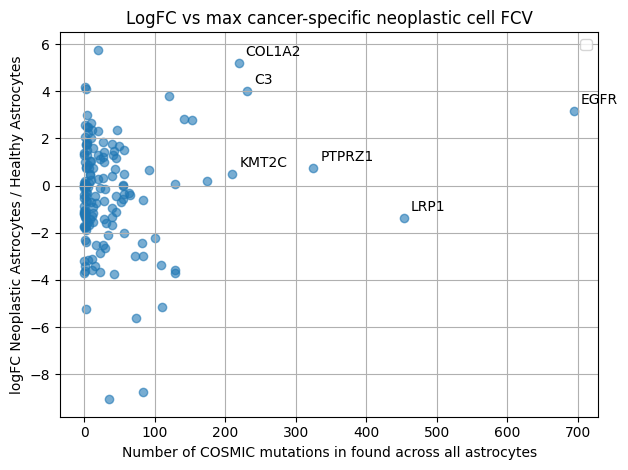

In [63]:
number_of_genes_to_label = 6

# Raw data
x = genes_grouped_df_astrocytes_for_plotting['number_variants_total_astrocyte']
y = genes_grouped_df_astrocytes_for_plotting['logfc_neoplastic_to_astrocytes']
genes = genes_grouped_df_astrocytes_for_plotting['gene_symbol']

mask = y > 10  # filter out y values > 10, and corresponding x's (None for nothing)

if mask is not None:
    x = x[~mask]
    y = y[~mask]
    genes = genes[~mask]

# Scatter plot
plt.scatter(x, y, alpha=0.6)

# # Best-fit line in linear space
# slope, intercept = np.polyfit(x, y, 1)
# x_fit = np.array([x.min(), x.max()])
# y_fit = slope * x_fit + intercept
# plt.plot(x_fit, y_fit, 'r--', label='Best-fit line')

# Annotate top number_of_genes_to_label x values
top_idx = x.nlargest(number_of_genes_to_label).index
for i in top_idx:
    plt.annotate(genes[i], (x[i], y[i]), textcoords="offset points", xytext=(5, 5), ha='left')

# Labels and formatting
plt.xlabel("Number of COSMIC mutations in found across all astrocytes")
plt.ylabel("logFC Neoplastic Astrocytes / Healthy Astrocytes")
plt.title("LogFC vs max cancer-specific neoplastic cell FCV")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


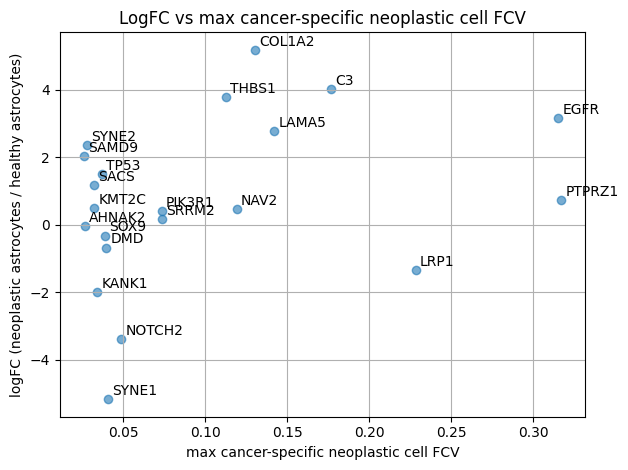

In [64]:
number_of_genes_to_label = 35
log_x = False

# Raw data
x = genes_grouped_df_astrocytes_for_plotting['max_FCV_neoplastic_astrocyte_cancer_specific']
y = genes_grouped_df_astrocytes_for_plotting['logfc_neoplastic_to_astrocytes']
genes = genes_grouped_df_astrocytes_for_plotting['gene_symbol']

mask = y > 10  # filter out y values > 10, and corresponding x's (None for nothing)

if mask is not None:
    x = x[~mask]
    y = y[~mask]
    genes = genes[~mask]

# Scatter plot
plt.scatter(x, y, alpha=0.6)

# # Best-fit line in linear space
# slope, intercept = np.polyfit(x, y, 1)
# x_fit = np.array([x.min(), x.max()])
# y_fit = slope * x_fit + intercept
# plt.plot(x_fit, y_fit, 'r--', label='Best-fit line')

# Annotate top number_of_genes_to_label x values
top_idx = x.nlargest(number_of_genes_to_label).index
for i in top_idx:
    plt.annotate(genes[i], (x[i], y[i]), textcoords="offset points", xytext=(3, 3), ha='left')

# Labels and formatting
plt.xlabel("max cancer-specific neoplastic cell FCV")
plt.ylabel("logFC (neoplastic astrocytes / healthy astrocytes)")
plt.title("LogFC vs max cancer-specific neoplastic cell FCV")
if log_x:
    plt.xscale('log')
# plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "astrocytes_logfc_vs_FCV.pdf"))
plt.show()
